<center><h1>Stack Overflow Developer Surveys, 2015-2019

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

%matplotlib inline
%config IPCompleter.greedy=True

In [181]:
# global printing options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 30

Questions explored:
1. Which are the current most commonly used programming languages?
2. How has the prevalance of different programming languages changed throughout the past **five????** years?
3. Which programming languages are the currently the most popular for specific types of developers?

Poss questions:

- mode of education + diff lang/frameworks/plats?
- years of experience + diff lang/frameworks/plats?

Challenges:

As is often the case with the practicalities of real-life data, the Stack Overflow developer survey varies each year, presenting unique challenges to making cross-year comparisons. 

1. The same languages are classified differently from year-to-year. For instance, HTML and CSS are combined under one category in the 2019 survey, categorized separately in the 2018 survey, and nonexistent in 2017 and prior surveys.
2. The question in 2017 covers "technologies that you work with", including languages, databases, platforms, and frameworks. The 2018 and 2019 surveys thankfully separated these different variables, but that still means more cleaning for the 2017 dataset!
3. The addition of an "Others" category in 2019 that replaces the most obscure entries from earlier years. For consistency across years, I opted to combine the obscure languages from before 2019 into a single category "Other(s)". 


Problem variables:

- HTML/CSS for 2019, 2018 has HTML and CSS separately.
- Bash/Shell/PowerShell for 2019, 2018 has Bash/Shell
- 2019 has an "Other" category

End goal - create a line graph of prevalence of languages across different years
2015

- [ ] implement Rhuzh's solution


2019: LanguageWorkedWith

2018: LanguageWorkedWith

2017: HaveWorkedLanguage

2016: tech_do

Broad Steps

1. Make a counts table of all languages
2. Visualize the language usage proportions over the 5 years.

### 2015


The 2015 and 2016 datasets has all technologies usage combined - languages, databases, frameworks, etc. The 2015 dataset was the easiest to clean of the 5 years because each technology already had its own column in the form of a boolean table. This made for an inefficiently large results table (possibly because the 2015 survey had less information overall than the other years) but very easy data preprocessing, since all I had to do was eliminate the unwanted columns and empty rows, and then sum up each column for the final counts table.

2015 Data cleaning steps:

1. Separating the "technologies used" sections from the entire datasets
2. Drop non-language columns 
3. Drop empty rows
4. Combine/change columns to match the Common Language categories (e.g. change name of VB column, combine C++ and C++ 11 columns, combine the uncommon languages into the "Others" category)
5. Create a new df of counts by counting the # of values in each column

### 2016

The 2016 datasets also has all technologies usage combined - languages, databases, frameworks, etc. 
2016 to 2019 datasets - the languages/technologies data was stored in a single series of string. Each survey response (a single cell) string was functionally a list (stored as a string in the format "value1; value2; value3").

An extra step was required to parse the series to obtain a list of all of the possible values in the series. For the 2016 dataset, this list was trimmed of the non-language values.

Data cleaning consists of:

1. Separating the "technologies used" column from the entire dataset.
2. Drop empty rows.
3. Split each string into a list of values with the delimiter "; ". Obtain a list of all values present.
4. Expand the series of lists to a dataframe, with each value in a list as a row with one value per cell. Create a transposed dataframe so that each series represents a respondent.
5. Using the list of all possible languages to filter the transposed dataframe, create a boolean dataframe of whether a respondent is Y/N for each value.
6. Combine/change columns to match the Common Language categories (e.g. change names and combine the VB columns, combine the uncommon languages into the "Others" category)
5. Create a new df of counts by counting the # of values in each column

### 2017-2019

The 2017 to 2019 datasets separated the survey questions about technologies used into languages, OS's, frameworks, etc. The data cleaning steps are very similar to those used for 2016. The only difference between 2017-19 and 2016 result from obtaining a list of all languages present for the current year at different steps.

---
# <center>Loading data and functions
---

In [27]:
'''
for years 2016-2019.
processes a a specified column from the raw imported dataframe
'''
def process_col(df, col):
    s = df[col]
    s = s.dropna()
    s_len = s.shape[0]
    cat_count, col_vals = eval_complex_col(df, col)
    s_split = s.str.split(pat = '; ')
    return s,s_len, s_split, cat_count, col_vals

In [18]:
def eval_complex_col(df, col):
    '''
    IN:
    df[col] - every str consists of one or more values (e.g. 'a, b, d')
    
    OUT:
    col_vals - All unique elements found in the column, listed alphabetically
    
    '''
    col_num = df[df[col].isnull() == 0].shape[0]
    col_df = df[col].value_counts().reset_index()
    col_df.rename(columns={'index': col, col:'count'}, inplace = True)
    col_series = pd.Series(col_df[col].unique()).dropna()
    clean_list = col_series.str.split(pat = ';').tolist()
    

    flat_list = []
    for sublist in clean_list:
        for item in sublist:
            flat_list.append(item)
    clean_series = pd.DataFrame(flat_list)
    clean_series[0] = clean_series[0].str.strip()

    col_vals = clean_series[0].unique()
    col_vals = pd.Series(sorted(col_vals))
    cat_count = clean_series[0].value_counts()
    
    
#    print('Unique Categories: ', col_vals)
    return cat_count, col_vals


In [19]:
def clean_df_cat(df, to_remove):
    '''
    Removes columns that match any of the values in the to_remove list

    '''
    for item in to_remove:
        for col in df.columns:
            if item.casefold() == col.casefold():
                df = df.drop(col, axis = 1)
    return df

In [20]:
'''
2016-2019
converts a series of lists into a df with each list as a row
also returns a transposed version.
'''

def s_of_lists_to_df(s):
    df = pd.DataFrame(item for item in s)
    df_transposed = df.transpose()
    return df, df_transposed

In [21]:

def make_df_bool(df, df_transposed, vals_list):
    '''
    for all years (2015-2019)
    creates a df of bool values based on whether each survey response has the value in vals_list.
    df: dataframe of survey responses, 
    vals_list: list of values for conditions of the new columns, with 1 col per val
    '''
    for item in vals_list:
        df[item] = df_transposed.iloc[:,:].isin([item]).sum()
    df_bool = df.loc[:,vals_list]
    return df_bool

In [22]:
'''
Condensed function processing from initial imported df to boolean df
Used for 2017-2019
'''
def process_data(df, col):
    df_droppedna, df_droppedna_len, df_droppedna_split, df_count, df_vals = process_col(df, col)
    df2, df2_transposed = s_of_lists_to_df(df_droppedna_split)
    df_bool = make_df_bool(df2, df2_transposed, df_vals)
    
    return df_bool, df_vals, df_droppedna_len



In [23]:
def process_data_extended(df, col, delimiter):
    '''
    for years 2017-2019.
    processes a specified column from the raw imported dataframe
    for 2017, delimiter = '; '
    for 2018+19, delimiter = ';'
    '''
    s = df[col]
    s = s.dropna()
    df_len = s.shape[0]
    df_count, df_vals = eval_complex_col(df, col)
    s_split = s.str.split(pat = delimiter)

    df_new = pd.DataFrame(item for item in s_split)
    df_new_transposed = df_new.transpose()

    for item in df_vals:
        df_new[item] = df_new_transposed.iloc[:,:].isin([item]).sum()
    df_bool = df_new.loc[:,df_vals]

    return df_bool, df_vals, df_len

In [24]:
'''
for all years (2015-2019)
must edit the df to match the lang_comm_list first!
Finds the difference between the languages of the current year and the list of common languages
Returns a list of columns to be merged into an "others" column
'''
def find_other_lang(df):
    other_lang = set(df.columns).difference(set(lang_comm_list))
    other_lang_list = list(other_lang)
    return other_lang_list


In [25]:
'''
for 2015 data - multiple columns for one data category
converts a dataframe into a 1-d series to a 2 column df,
returned df has Columns and column counts
series sorted alphabetically
'''
def make_counts2015(ini_df, series_name, index_name):
    series = ini_df.count()
    series = series.rename_axis(index_name)
    series = series.rename(series_name).sort_index()
    df = series.reset_index()
#    df.sort_values(by=[sort_by], inplace = True)
    return series, df

In [26]:
'''
2016-2019
creates a df of counts for each column of the boolean df
'''
def make_counts(ini_df, series_name, index_name):
    series = ini_df.sum()
    series = series.rename_axis(index_name)
    series = series.rename(series_name).sort_index()
    df = series.reset_index()
#    df.sort_values(by=[sort_by], inplace = True)
    return series, df

In [3]:
df2019 = pd.read_csv('./2019survey_results_public.csv', header = 0, skipinitialspace= True, low_memory=False)
df2018 = pd.read_csv('./2018survey_results_public.csv', header = 0, skipinitialspace= True, low_memory=False)
df2017 = pd.read_csv('./2017survey_results_public.csv', header = 0, skipinitialspace= True, low_memory=False)
df2016 = pd.read_csv('./2016survey_results.csv', header = 0, skipinitialspace= True, low_memory=False)
df2015 = pd.read_csv('./2015survey_results.csv', header = 1, skipinitialspace= True, low_memory=False)

Professional, EmploymentStatus: languages?

In [4]:
display(df2019.head())

Respondent                                         MainBranch Hobbyist  \
0           1             I am a student who is learning to code      Yes   
1           2             I am a student who is learning to code       No   
2           3  I am not primarily a developer, but I write co...      Yes   
3           4                     I am a developer by profession       No   
4           5                     I am a developer by profession      Yes   

                  OpenSourcer  \
0                       Never   
1     Less than once per year   
2                       Never   
3                       Never   
4  Once a month or more often   

                                          OpenSource  \
0  The quality of OSS and closed source software ...   
1  The quality of OSS and closed source software ...   
2  The quality of OSS and closed source software ...   
3  The quality of OSS and closed source software ...   
4  OSS is, on average, of HIGHER quality than pro...   

                               Employment                 Country  \
0  Not employed, and not looking for work          United Kingdom   
1      Not employed, but looking for work  Bosnia and Herzegovina   
2                      Employed full-time                Thailand   
3                      Employed full-time           United States   
4                      Employed full-time                 Ukraine   

          Student                                            EdLevel  \
0              No                          Primary/elementary school   
1  Yes, full-time  Secondary school (e.g. American high school, G...   
2              No           Bachelor’s degree (BA, BS, B.Eng., etc.)   
3              No           Bachelor’s degree (BA, BS, B.Eng., etc.)   
4              No           Bachelor’s degree (BA, BS, B.Eng., etc.)   

                                      UndergradMajor  \
0                                                NaN   
1                                                NaN   
2                      Web development or web design   
3  Computer science, computer engineering, or sof...   
4  Computer science, computer engineering, or sof...   

                                            EduOther  \
0  Taught yourself a new language, framework, or ...   
1  Taken an online course in programming or softw...   
2  Taught yourself a new language, framework, or ...   
3  Taken an online course in programming or softw...   
4  Taken an online course in programming or softw...   

                    OrgSize  \
0                       NaN   
1                       NaN   
2      100 to 499 employees   
3      100 to 499 employees   
4  10,000 or more employees   

                                             DevType YearsCode Age1stCode  \
0                                                NaN         4         10   
1  Developer, desktop or enterprise applications;...       NaN         17   
2  Designer;Developer, back-end;Developer, front-...         3         22   
3                              Developer, full-stack         3         16   
4  Academic researcher;Developer, desktop or ente...        16         14   

       YearsCodePro           CareerSat                 JobSat  \
0               NaN                 NaN                    NaN   
1               NaN                 NaN                    NaN   
2                 1  Slightly satisfied     Slightly satisfied   
3  Less than 1 year      Very satisfied     Slightly satisfied   
4                 9   Very dissatisfied  Slightly dissatisfied   

               MgrIdiot  MgrMoney   MgrWant  \
0                   NaN       NaN       NaN   
1                   NaN       NaN       NaN   
2  Not at all confident  Not sure  Not sure   
3        Very confident        No  Not sure   
4    Somewhat confident       Yes        No   

                                             JobSeek          LastHireDate  \
0                                                NaN                   NaN

In [5]:
df2019.describe()

Respondent     CompTotal  ConvertedComp   WorkWeekHrs    CodeRevHrs  \
count  88883.000000  5.594500e+04   5.582300e+04  64503.000000  49790.000000   
mean   44442.000000  5.519014e+11   1.271107e+05     42.127197      5.084308   
std    25658.456325  7.331926e+13   2.841523e+05     37.287610      5.513931   
min        1.000000  0.000000e+00   0.000000e+00      1.000000      0.000000   
25%    22221.500000  2.000000e+04   2.577750e+04     40.000000      2.000000   
50%    44442.000000  6.200000e+04   5.728700e+04     40.000000      4.000000   
75%    66662.500000  1.200000e+05   1.000000e+05     44.750000      6.000000   
max    88883.000000  1.000000e+16   2.000000e+06   4850.000000     99.000000   

                Age  
count  79210.000000  
mean      30.336699  
std        9.178390  
min        1.000000  
25%       24.000000  
50%       29.000000  
75%       35.000000  
max       99.000000

In [7]:
#Investigate missing data using different thresholds of %NaN missing.
def investigate_nan_threshold(df, interval, start):
    '''
This function finds how many columns have more than a certain percentage 
of data missing.

INPUTS:
    start - the initial threshold percentage of data missing to be analyzed
    interval - the amount of increase in the analysis threshold 
    if the previous threshold has at least 1 column remaining

OUTPUTS:
    Prints the names of the columns that have more than the threshold % of 
    data missing as well as the current threshold.
    '''

    n = start
    df_rows, df_cols = df.shape
    missing_list = [1]
    while len(missing_list) > 0:
        missing_list = [col for col in df.columns if (df[col].isnull().sum()/df_rows)*100 > n]
        if len(missing_list) > 0:
            print('There are {} columns with more than {}% of data missing.'.format(len(missing_list), n))
            print(missing_list)
            print('--------------------------------------')
            n = n+interval
        else:
            break


In [8]:
investigate_nan_threshold(df2019, 10, 5)

There are 54 columns with more than 5% of data missing.
['UndergradMajor', 'EduOther', 'OrgSize', 'DevType', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat', 'LanguageDesireNextYear', 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith', 'PlatformDesireNextYear', 'WebFrameWorkedWith', 'WebFrameDesireNextYear', 'MiscTechWorkedWith', 'MiscTechDesireNextYear', 'BlockchainOrg', 'BlockchainIs', 'SocialMedia', 'ScreenName', 'SOVisit1st', 'SOHowMuchTime', 'SOPartFreq', 'SONewContent', 'Age', 'Trans', 'Sexuality', 'Ethnicity', 'Dependents']
--------------------------------------
There are 35 columns with more than 15% of data missing.
['OrgSize', 'YearsCo

In [9]:
df2019_dropped = df2019.drop('BlockchainOrg', axis = 1)

In [10]:
df2019_dropped

Respondent                                         MainBranch Hobbyist  \
0               1             I am a student who is learning to code      Yes   
1               2             I am a student who is learning to code       No   
2               3  I am not primarily a developer, but I write co...      Yes   
3               4                     I am a developer by profession       No   
4               5                     I am a developer by profession      Yes   
...           ...                                                ...      ...   
88878       88377                                                NaN      Yes   
88879       88601                                                NaN       No   
88880       88802                                                NaN       No   
88881       88816                                                NaN       No   
88882       88863                                                NaN      Yes   

                                             OpenSourcer  \
0                                                  Never   
1                                Less than once per year   
2                                                  Never   
3                                                  Never   
4                             Once a month or more often   
...                                                  ...   
88878  Less than once a month but more than once per ...   
88879                                              Never   
88880                                              Never   
88881                                              Never   
88882                            Less than once per year   

                                              OpenSource  \
0      The quality of OSS and closed source software ...   
1      The quality of OSS and closed source software ...   
2      The quality of OSS and closed source software ...   
3      The quality of OSS and closed source software ...   
4      OSS is, on average, of HIGHER quality than pro...   
...                                                  ...   
88878  The quality of OSS and closed source software ...   
88879  The quality of OSS and closed source software ...   
88880                                                NaN   
88881  OSS is, on average, of HIGHER quality than pro...   
88882  OSS is, on average, of HIGHER quality than pro...   

                                              Employment  \
0                 Not employed, and not looking for work   
1                     Not employed, but looking for work   
2                                     Employed full-time   
3                                     Employed full-time   
4                                     Employed full-time   
...                                                  ...   
88878             Not employed, and not looking for work   
88879                                                NaN   
88880                                 Employed full-time   
88881  Independent contractor, freelancer, or self-em...   
88882             Not employed, and not looking for work   

                      Country         Student  \
0              United Kingdom              No   
1      Bosnia and Herzegovina  Yes, full-time   
2                    Thailand              No   
3               United States              No   
4                     Ukraine              No   
...                       ...             ...   
88878                  Canada              No   
88879                     NaN             NaN   
88880                     NaN             NaN   
88881                     NaN             NaN   
88882                   Spain  Yes, full-time   

                                                 EdLevel  \
0                              Primary/elementary school   
1      Secondary school (e.g. American high school, G...   
2               Bachelor’s degree (BA, BS, B.Eng., etc.)   
3               Bachelor’s degree (BA, BS,

In [11]:
df19_by_income = df2019_dropped[df2019_dropped['ConvertedComp'].isnull() == 0]

In [12]:
df19_dev_byincome = df19_by_income[df19_by_income['MainBranch'] == 'I am a developer by profession']

In [13]:
df19_dev_byincome

Respondent                      MainBranch Hobbyist  \
3               4  I am a developer by profession       No   
8               9  I am a developer by profession      Yes   
9              10  I am a developer by profession      Yes   
12             13  I am a developer by profession      Yes   
13             14  I am a developer by profession      Yes   
...           ...                             ...      ...   
88325       88878  I am a developer by profession      Yes   
88326       88879  I am a developer by profession      Yes   
88328       88881  I am a developer by profession      Yes   
88329       88882  I am a developer by profession      Yes   
88330       88883  I am a developer by profession      Yes   

                                             OpenSourcer  \
3                                                  Never   
8                             Once a month or more often   
9                             Once a month or more often   
12     Less than once a month but more than once per ...   
13                               Less than once per year   
...                                                  ...   
88325                            Less than once per year   
88326                                              Never   
88328                         Once a month or more often   
88329                                              Never   
88330                         Once a month or more often   

                                              OpenSource          Employment  \
3      The quality of OSS and closed source software ...  Employed full-time   
8      The quality of OSS and closed source software ...  Employed full-time   
9      OSS is, on average, of HIGHER quality than pro...  Employed full-time   
12     OSS is, on average, of HIGHER quality than pro...  Employed full-time   
13     The quality of OSS and closed source software ...  Employed full-time   
...                                                  ...                 ...   
88325  The quality of OSS and closed source software ...  Employed full-time   
88326  The quality of OSS and closed source software ...  Employed full-time   
88328  OSS is, on average, of HIGHER quality than pro...  Employed full-time   
88329  OSS is, on average, of LOWER quality than prop...  Employed full-time   
88330  OSS is, on average, of HIGHER quality than pro...  Employed full-time   

             Country         Student  \
3      United States              No   
8        New Zealand              No   
9              India              No   
12     United States              No   
13           Germany              No   
...              ...             ...   
88325  United States              No   
88326        Finland              No   
88328        Austria              No   
88329    Netherlands  Yes, full-time   
88330         Greece              No   

                                                 EdLevel  \
3               Bachelor’s degree (BA, BS, B.Eng., etc.)   
8      Some college/university study without earning ...   
9            Master’s degree (MA, MS, M.Eng., MBA, etc.)   
12           Master’s degree (MA, MS, M.Eng., MBA, etc.)   
13             Other doctoral degree (Ph.D, Ed.D., etc.)   
...                                                  ...   
88325           Bachelor’s degree (BA, BS, B.Eng., etc.)   
88326        Master’s degree (MA, MS, M.Eng., MBA, etc.)   
88328        Master’s degree (MA, MS, M.Eng., MBA, etc.)   
88329        Master’s degree (MA, MS, M.Eng., MBA, etc.)   
88330           Bachelor’s degree (BA, BS, B.Eng., etc.)   

                                          UndergradMajor  \
3      Computer science, computer engineering, or sof...   
8      Computer science, computer engineering, or sof...   
9                                                    NaN   
12     Computer science, computer engineering, or sof...   
13     Computer science, computer engineering, or sof...   
...               

In [14]:
row_threshold = 45
df2019_lowmiss = df19_dev_byincome[df19_dev_byincome.isnull().sum(axis=1) < row_threshold].reset_index(drop=True)


In [15]:
df2019_lowmiss

Respondent                      MainBranch Hobbyist  \
0               4  I am a developer by profession       No   
1               9  I am a developer by profession      Yes   
2              10  I am a developer by profession      Yes   
3              13  I am a developer by profession      Yes   
4              14  I am a developer by profession      Yes   
...           ...                             ...      ...   
50493       88878  I am a developer by profession      Yes   
50494       88879  I am a developer by profession      Yes   
50495       88881  I am a developer by profession      Yes   
50496       88882  I am a developer by profession      Yes   
50497       88883  I am a developer by profession      Yes   

                                             OpenSourcer  \
0                                                  Never   
1                             Once a month or more often   
2                             Once a month or more often   
3      Less than once a month but more than once per ...   
4                                Less than once per year   
...                                                  ...   
50493                            Less than once per year   
50494                                              Never   
50495                         Once a month or more often   
50496                                              Never   
50497                         Once a month or more often   

                                              OpenSource          Employment  \
0      The quality of OSS and closed source software ...  Employed full-time   
1      The quality of OSS and closed source software ...  Employed full-time   
2      OSS is, on average, of HIGHER quality than pro...  Employed full-time   
3      OSS is, on average, of HIGHER quality than pro...  Employed full-time   
4      The quality of OSS and closed source software ...  Employed full-time   
...                                                  ...                 ...   
50493  The quality of OSS and closed source software ...  Employed full-time   
50494  The quality of OSS and closed source software ...  Employed full-time   
50495  OSS is, on average, of HIGHER quality than pro...  Employed full-time   
50496  OSS is, on average, of LOWER quality than prop...  Employed full-time   
50497  OSS is, on average, of HIGHER quality than pro...  Employed full-time   

             Country         Student  \
0      United States              No   
1        New Zealand              No   
2              India              No   
3      United States              No   
4            Germany              No   
...              ...             ...   
50493  United States              No   
50494        Finland              No   
50495        Austria              No   
50496    Netherlands  Yes, full-time   
50497         Greece              No   

                                                 EdLevel  \
0               Bachelor’s degree (BA, BS, B.Eng., etc.)   
1      Some college/university study without earning ...   
2            Master’s degree (MA, MS, M.Eng., MBA, etc.)   
3            Master’s degree (MA, MS, M.Eng., MBA, etc.)   
4              Other doctoral degree (Ph.D, Ed.D., etc.)   
...                                                  ...   
50493           Bachelor’s degree (BA, BS, B.Eng., etc.)   
50494        Master’s degree (MA, MS, M.Eng., MBA, etc.)   
50495        Master’s degree (MA, MS, M.Eng., MBA, etc.)   
50496        Master’s degree (MA, MS, M.Eng., MBA, etc.)   
50497           Bachelor’s degree (BA, BS, B.Eng., etc.)   

                                          UndergradMajor  \
0      Computer science, computer engineering, or sof...   
1      Computer science, computer engineering, or sof...   
2                                                    NaN   
3      Computer science, computer engineering, or sof...   
4      Computer science, computer engineering, or sof...   
...               

In [16]:
def process_data_extended(df, col, delimiter):
    '''
    for years 2017-2019.
    processes a specified column from the raw imported dataframe
    for 2017, delimiter = '; '
    for 2018+19, delimiter = ';'
    '''
    s = df[col]
    s = s.dropna()
    df_len = s.shape[0]
    df_count, df_vals = eval_complex_col(df, col)
    s_split = s.str.split(pat = delimiter)

    df_new = pd.DataFrame(item for item in s_split)
    df_new_transposed = df_new.transpose()

    for item in df_vals:
        df_new[item] = df_new_transposed.iloc[:,:].isin([item]).sum()
    df_bool = df_new.loc[:,df_vals]

    return df_bool, df_vals, df_len

In [28]:
#Drop empty rows, split each cell string into a list via a delimiter, obtain list of all languages present for the year
#convert the lists into a dataframe. 
#for each language present in the year, create a boolean for whether each respondent has the language in their list 
dflang2019_bool, lang2019_vals, lang2019_len = process_data_extended(df2019, 'LanguageWorkedWith', delimiter = ';')

In [29]:

eduother_bool, eduother_vals, eduother_len = process_data_extended(df2019_lowmiss, 'EduOther', ';')

In [30]:
devtype_bool, devtype_vals_2, devtype_len = process_data_extended(df2019_lowmiss, 'DevType', ';')

In [182]:
dflang2019_bool

Bash/Shell/PowerShell  C  C#  C++  Clojure  F#  Go  HTML/CSS  Java  \
0                          0  0   0    0        0   0   0         1     1   
1                          0  0   0    1        0   0   0         1     0   
2                          0  0   0    0        0   0   0         1     0   
3                          0  1   1    1        0   0   0         0     0   
4                          0  0   0    1        0   0   0         1     1   
...                      ... ..  ..  ...      ...  ..  ..       ...   ...   
87564                      0  0   0    0        0   0   0         1     1   
87565                      0  0   0    0        0   0   0         1     0   
87566                      1  0   0    0        0   0   1         1     0   
87567                      0  0   0    0        0   0   0         1     0   
87568                      1  0   0    0        0   0   0         1     1   

       JavaScript  Objective-C  PHP  Python  R  Ruby  Rust  SQL  Scala  Swift  \
0               1            0    0       1  0     0     0    0      0      0   
1               0            0    0       1  0     0     0    0      0      0   
2               0            0    0       0  0     0     0    0      0      0   
3               0            0    0       1  0     0     0    1      0      0   
4               1            0    0       1  0     0     0    1      0      0   
...           ...          ...  ...     ... ..   ...   ...  ...    ...    ...   
87564           1            0    0       0  0     0     0    0      0      0   
87565           1            0    0       1  0     0     0    0      0      0   
87566           1            0    0       0  0     0     0    0      0      0   
87567           1            0    0       0  0     0     0    0      0      0   
87568           1            0    1       0  0     0     0    1      0      1   

       Visual Basic / VBA  Other(s)  
0                       0         0  
1                       0         0  
2                       0         0  
3                       0         0  
4                       1         0  
...                   ...       ...  
87564                   0         0  
87565                   0         0  
87566                   0         1  
87567                   0         1  
87568                   0         0  

[87569 rows x 21 columns]

In [31]:
to_merge = [eduother_bool, devtype_bool, dflang2019_bool]

In [32]:
merged_df19 = df2019_lowmiss.copy()
for cat in to_merge:
    merged_df19 = pd.DataFrame.merge(merged_df19, cat, left_index = True, right_index = True)

In [33]:
merged_df19

Respondent                      MainBranch Hobbyist  \
0               4  I am a developer by profession       No   
1               9  I am a developer by profession      Yes   
2              10  I am a developer by profession      Yes   
3              13  I am a developer by profession      Yes   
4              14  I am a developer by profession      Yes   
...           ...                             ...      ...   
48983       86223  I am a developer by profession      Yes   
48984       86224  I am a developer by profession       No   
48985       86225  I am a developer by profession      Yes   
48986       86226  I am a developer by profession       No   
48987       86227  I am a developer by profession      Yes   

                                             OpenSourcer  \
0                                                  Never   
1                             Once a month or more often   
2                             Once a month or more often   
3      Less than once a month but more than once per ...   
4                                Less than once per year   
...                                                  ...   
48983  Less than once a month but more than once per ...   
48984                            Less than once per year   
48985                                              Never   
48986                                              Never   
48987                                              Never   

                                              OpenSource          Employment  \
0      The quality of OSS and closed source software ...  Employed full-time   
1      The quality of OSS and closed source software ...  Employed full-time   
2      OSS is, on average, of HIGHER quality than pro...  Employed full-time   
3      OSS is, on average, of HIGHER quality than pro...  Employed full-time   
4      The quality of OSS and closed source software ...  Employed full-time   
...                                                  ...                 ...   
48983  OSS is, on average, of HIGHER quality than pro...  Employed full-time   
48984  The quality of OSS and closed source software ...  Employed full-time   
48985  OSS is, on average, of HIGHER quality than pro...  Employed full-time   
48986  The quality of OSS and closed source software ...  Employed full-time   
48987  OSS is, on average, of HIGHER quality than pro...  Employed full-time   

                  Country Student_x  \
0           United States        No   
1             New Zealand        No   
2                   India        No   
3           United States        No   
4                 Germany        No   
...                   ...       ...   
48983             Ireland        No   
48984  Russian Federation        No   
48985              Sweden        No   
48986       United States        No   
48987             Germany        No   

                                                 EdLevel  \
0               Bachelor’s degree (BA, BS, B.Eng., etc.)   
1      Some college/university study without earning ...   
2            Master’s degree (MA, MS, M.Eng., MBA, etc.)   
3            Master’s degree (MA, MS, M.Eng., MBA, etc.)   
4              Other doctoral degree (Ph.D, Ed.D., etc.)   
...                                                  ...   
48983        Master’s degree (MA, MS, M.Eng., MBA, etc.)   
48984           Bachelor’s degree (BA, BS, B.Eng., etc.)   
48985  Some college/university study without earning ...   
48986           Bachelor’s degree (BA, BS, B.Eng., etc.)   
48987  Secondary school (e.g. American high school, G...   

                                          UndergradMajor  \
0      Computer science, computer engineering, or sof...   
1      Computer science, computer engineering, or sof...   
2                                                    NaN   
3      Computer science, computer engineering, or sof...   
4      Computer science, computer engineering, or sof...   
...                           

In [ ]:
#azdias_remain.loc[:, 'OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace = True)

In [ ]:
#df2019_lowmiss.groupby(['Hobbyist']).mean()

In [113]:
#df2019_lowmiss.groupby(['Hobbyist']).mean()['ConvertedComp'].sort_values()

Hobbyist
0    126090.787293
1    127365.796604
Name: ConvertedComp, dtype: float64

In [35]:
list(merged_df19.columns)

['Respondent',
 'MainBranch',
 'Hobbyist',
 'OpenSourcer',
 'OpenSource',
 'Employment',
 'Country',
 'Student_x',
 'EdLevel',
 'UndergradMajor',
 'EduOther',
 'OrgSize',
 'DevType',
 'YearsCode',
 'Age1stCode',
 'YearsCodePro',
 'CareerSat',
 'JobSat',
 'MgrIdiot',
 'MgrMoney',
 'MgrWant',
 'JobSeek',
 'LastHireDate',
 'LastInt',
 'FizzBuzz',
 'JobFactors',
 'ResumeUpdate',
 'CurrencySymbol',
 'CurrencyDesc',
 'CompTotal',
 'CompFreq',
 'ConvertedComp',
 'WorkWeekHrs',
 'WorkPlan',
 'WorkChallenge',
 'WorkRemote',
 'WorkLoc',
 'ImpSyn',
 'CodeRev',
 'CodeRevHrs',
 'UnitTests',
 'PurchaseHow',
 'PurchaseWhat',
 'LanguageWorkedWith',
 'LanguageDesireNextYear',
 'DatabaseWorkedWith',
 'DatabaseDesireNextYear',
 'PlatformWorkedWith',
 'PlatformDesireNextYear',
 'WebFrameWorkedWith',
 'WebFrameDesireNextYear',
 'MiscTechWorkedWith',
 'MiscTechDesireNextYear',
 'DevEnviron',
 'OpSys',
 'Containers',
 'BlockchainIs',
 'BetterLife',
 'ITperson',
 'OffOn',
 'SocialMedia',
 'Extraversion',
 'Sc

In [34]:
merged_df19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48988 entries, 0 to 48987
Columns: 145 entries, Respondent to WebAssembly
dtypes: float64(5), int64(62), object(78)
memory usage: 54.6+ MB


In [421]:
list(merged_df19.columns)
#list to_drop below

['Respondent',
 'MainBranch',
 'Hobbyist',
 'OpenSourcer',
 'OpenSource',
 'Employment',
 'Country',
 'Student',
 'EdLevel',
 'UndergradMajor',
 'EduOther',
 'OrgSize',
 'DevType',
 'YearsCode',
 'Age1stCode',
 'YearsCodePro',
 'CareerSat',
 'JobSat',
 'MgrIdiot',
 'MgrMoney',
 'MgrWant',
 'JobSeek',
 'LastHireDate',
 'LastInt',
 'FizzBuzz',
 'JobFactors',
 'ResumeUpdate',
 'CurrencySymbol',
 'CurrencyDesc',
 'CompTotal',
 'CompFreq',
 'ConvertedComp',
 'WorkWeekHrs',
 'WorkPlan',
 'WorkChallenge',
 'WorkRemote',
 'WorkLoc',
 'ImpSyn',
 'CodeRev',
 'CodeRevHrs',
 'UnitTests',
 'PurchaseHow',
 'PurchaseWhat',
 'LanguageWorkedWith',
 'LanguageDesireNextYear',
 'DatabaseWorkedWith',
 'DatabaseDesireNextYear',
 'PlatformWorkedWith',
 'PlatformDesireNextYear',
 'WebFrameWorkedWith',
 'WebFrameDesireNextYear',
 'MiscTechWorkedWith',
 'MiscTechDesireNextYear',
 'DevEnviron',
 'OpSys',
 'Containers',
 'BlockchainIs',
 'BetterLife',
 'ITperson',
 'OffOn',
 'SocialMedia',
 'Extraversion',
 'Scre

In [36]:
to_drop = ['Respondent',
 'MainBranch',
 'Hobbyist',
 'OpenSourcer',
 'OpenSource',
 'Employment',
 'Country',
 'Student_x',
 'EduOther',
 'DevType',
 'Age1stCode',
 'YearsCodePro',
 'MgrIdiot',
 'MgrMoney',
 'MgrWant',
 'JobSeek',
 'LastHireDate',
 'LastInt',
 'FizzBuzz',
 'JobFactors',
 'ResumeUpdate',
 'CurrencySymbol',
 'CurrencyDesc',
 'CompTotal',
 'CompFreq',
 'WorkWeekHrs',
 'WorkPlan',
 'WorkChallenge',
 'WorkRemote',
 'WorkLoc',
 'ImpSyn',
 'CodeRev',
 'UnitTests',
 'PurchaseHow',
 'PurchaseWhat',
 'LanguageWorkedWith',
 'LanguageDesireNextYear',
 'DatabaseWorkedWith',
 'DatabaseDesireNextYear',
 'PlatformWorkedWith',
 'PlatformDesireNextYear',
 'WebFrameWorkedWith',
 'WebFrameDesireNextYear',
 'MiscTechWorkedWith',
 'MiscTechDesireNextYear',
 'DevEnviron',
 'OpSys',
 'Containers',
 'BlockchainIs',
 'BetterLife',
 'ITperson',
 'OffOn',
 'SocialMedia',
 'Extraversion',
 'ScreenName',
 'SOVisit1st',
 'SOVisitFreq',
 'SOVisitTo',
 'SOFindAnswer',
 'SOTimeSaved',
 'SOHowMuchTime',
 'SOAccount',
 'SOPartFreq',
 'SOJobs',
 'EntTeams',
 'SOComm',
 'WelcomeChange',
 'SONewContent',
 'Trans',
 'Sexuality',
 'Ethnicity',
 'Dependents',
 'SurveyLength',
 'SurveyEase']

In [37]:
#drop the excess columns
merged_df19_dropped = merged_df19.drop(to_drop, axis = 1)

In [38]:
merged_df19_dropped.columns

Index(['EdLevel', 'UndergradMajor', 'OrgSize', 'YearsCode', 'CareerSat',
       'JobSat', 'ConvertedComp', 'CodeRevHrs', 'Age', 'Gender',
       'Completed an industry certification program (e.g. MCPD)',
       'Contributed to open source software',
       'Participated in a full-time developer training program or bootcamp',
       'Participated in a hackathon',
       'Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)',
       'Received on-the-job training in software development',
       'Taken a part-time in-person course in programming or software development',
       'Taken an online course in programming or software development (e.g. a MOOC)',
       'Taught yourself a new language, framework, or tool without taking a formal course',
       'Academic researcher', 'Data or business analyst',
       'Data scientist or machine learning specialist',
       'Database administrator', 'Designer', 'DevOps specialist',
       'Developer, QA or test', 'Develo

In [331]:
eval_complex_col(df2019, 'CareerSat')

(Very dissatisfied                     1
 Slightly satisfied                    1
 Neither satisfied nor dissatisfied    1
 Slightly dissatisfied                 1
 Very satisfied                        1
 Name: 0, dtype: int64, 0    Neither satisfied nor dissatisfied
 1                 Slightly dissatisfied
 2                    Slightly satisfied
 3                     Very dissatisfied
 4                        Very satisfied
 dtype: object)

In [349]:
list(eval_complex_col(df2019, 'OrgSize'))[0].index

Index(['10,000 or more employees', '5,000 to 9,999 employees',
       '100 to 499 employees', '20 to 99 employees', '2-9 employees',
       '500 to 999 employees', '1,000 to 4,999 employees',
       'Just me - I am a freelancer, sole proprietor, etc.',
       '10 to 19 employees'],
      dtype='object')

In [336]:
merged_df19_dropped

Hobbyist              CareerSat                 JobSat  ConvertedComp  \
2             1     Slightly satisfied     Slightly satisfied         8820.0   
3             0         Very satisfied     Slightly satisfied        61000.0   
5             1         Very satisfied     Slightly satisfied       366420.0   
8             1     Slightly satisfied     Slightly satisfied        95179.0   
9             1  Slightly dissatisfied  Slightly dissatisfied        13293.0   
...         ...                    ...                    ...            ...   
80864         1         Very satisfied     Slightly satisfied       110000.0   
80865         1     Slightly satisfied     Slightly satisfied      1620000.0   
80866         1         Very satisfied     Slightly satisfied        32784.0   
80869         1         Very satisfied         Very satisfied       152160.0   
80870         0     Slightly satisfied     Slightly satisfied        68745.0   

        Age Gender  Bash/Shell/PowerShell  C  C#  C++  Clojure  F#  Go  \
2      28.0    Man                      0  0   0    0        0   0   0   
3      22.0    Man                      0  1   1    1        0   0   0   
5      28.0    Man                      0  0   0    0        0   0   0   
8      23.0    Man                      1  0   1    0        0   0   0   
9       NaN    NaN                      0  0   1    0        0   0   1   
...     ...    ...                    ... ..  ..  ...      ...  ..  ..   
80864  57.0    Man                      0  0   0    0        0   0   0   
80865  30.0    Man                      1  1   1    1        0   0   0   
80866  34.0    Man                      0  0   0    0        0   0   0   
80869  27.0    Man                      0  0   1    0        0   0   0   
80870  35.0    Man                      0  1   1    1        0   0   0   

       HTML/CSS  Java  JavaScript  Objective-C  PHP  Python  R  Ruby  Rust  \
2             1     0           0            0    0       0  0     0     0   
3             0     0           0            0    0       1  0     0     0   
5             0     1           0            0    0       0  1     0     0   
8             1     0           1            0    0       1  0     1     1   
9             0     0           1            0    0       1  1     0     0   
...         ...   ...         ...          ...  ...     ... ..   ...   ...   
80864         0     0           0            1    0       0  0     0     0   
80865         0     1           1            0    0       1  0     0     0   
80866         0     1           1            1    1       0  0     0     0   
80869         1     0           1            0    0       0  0     0     0   
80870         1     1           1            0    0       1  0     0     0   

       SQL  Scala  Swift  Visual Basic / VBA  Other(s)  Academic researcher  \
2        0      0      0                   0         0                    0   
3        1      0      0                   0         0                    1   
5        1      0      0                   0         0                    0   
8        1      0      0                   0         1                    0   
9        1      0      0                   0         0                    0   
...    ...    ...    ...                 ...       ...                  ...   
80864    0      0      1                   0         0                    0   
80865    0      0      0                   0         1                    0   
80866    0      0      1                   0         1                    0   
80869    0      0      0                   0         0                    0   
80870    1      0      0                   0         1                    0   

       Data or business analyst  \
2                             0   
3                             0   
5                             0   
8                             1   
9                             1   
...                         ...   
80864                     

In [43]:
eval_complex_col(df2019, 'YearsCode')

(12                    1
 16                    1
 5                     1
 11                    1
 25                    1
                      ..
 3                     1
 More than 50 years    1
 48                    1
 38                    1
 13                    1
 Name: 0, Length: 52, dtype: int64, 0                      1
 1                     10
 2                     11
 3                     12
 4                     13
              ...        
 47                     7
 48                     8
 49                     9
 50      Less than 1 year
 51    More than 50 years
 Length: 52, dtype: object)

In [123]:
'''
2016-2019
creates a df of counts for each column of the boolean df
'''
def make_counts(ini_df, series_name, index_name):
    series = ini_df.sum()
    series = series.rename_axis(index_name)
    series = series.rename(series_name).sort_index()
    df = series.reset_index()
#    df.sort_values(by=[sort_by], inplace = True)
    return series, df

In [232]:
s_devtype = pd.Series(eval_complex_col(merged_df19, 'DevType'))

In [242]:
devtype_vals = s_devtype[0].index

In [249]:
devtype_vals_2

0                               Academic researcher
1                          Data or business analyst
2     Data scientist or machine learning specialist
3                            Database administrator
4                                          Designer
5                                 DevOps specialist
6                             Developer, QA or test
7                               Developer, back-end
8     Developer, desktop or enterprise applications
9       Developer, embedded applications or devices
10                             Developer, front-end
11                            Developer, full-stack
12                      Developer, game or graphics
13                                Developer, mobile
14                                         Educator
15                                   Engineer, data
16                       Engineer, site reliability
17                              Engineering manager
18                  Marketing or sales professional
19          

In [243]:
devtype_vals

Index(['Developer, back-end', 'Developer, full-stack', 'Developer, front-end',
       'Developer, desktop or enterprise applications',
       'Database administrator', 'System administrator', 'Developer, mobile',
       'Designer', 'DevOps specialist', 'Student', 'Data or business analyst',
       'Developer, embedded applications or devices', 'Developer, QA or test',
       'Engineer, data', 'Academic researcher',
       'Data scientist or machine learning specialist', 'Educator',
       'Product manager', 'Developer, game or graphics', 'Engineering manager',
       'Scientist', 'Engineer, site reliability', 'Senior executive/VP',
       'Marketing or sales professional'],
      dtype='object')

In [245]:
dfdevtype_new = pd.DataFrame(item for item in devtype_vals)
dfdevtype_new_tp = dfdevtype_new.transpose()

In [ ]:
    for item in devtype_vals:
        df_new[item] = df_new_transposed.iloc[:,:].isin([item]).sum()
    df_bool = df_new.loc[:,df_vals]

In [203]:
col_list = []
for x  in merged_df19.columns:
    col_list.append(x)

In [224]:
to_dummy = [ 'Employment',
 'EdLevel',
 'UndergradMajor',
 'EduOther',
 'OrgSize',
 'Gender']

In [210]:
from pandas import get_dummies

In [225]:
df19_dummy = pd.get_dummies(merged_df19[to_dummy].astype(str))

In [399]:
df19_dummy

EdLevel_Associate degree  \
3                             0   
4                             0   
6                             0   
8                             0   
9                             0   
...                         ...   
80865                         0   
80866                         0   
80869                         0   
80870                         0   
80871                         0   

       EdLevel_Bachelor’s degree (BA, BS, B.Eng., etc.)  \
3                                                     1   
4                                                     1   
6                                                     1   
8                                                     0   
9                                                     0   
...                                                 ...   
80865                                                 1   
80866                                                 1   
80869                                                 1   
80870                                                 1   
80871                                                 0   

       EdLevel_I never completed any formal education  \
3                                                   0   
4                                                   0   
6                                                   0   
8                                                   0   
9                                                   0   
...                                               ...   
80865                                               0   
80866                                               0   
80869                                               0   
80870                                               0   
80871                                               0   

       EdLevel_Master’s degree (MA, MS, M.Eng., MBA, etc.)  \
3                                                      0     
4                                                      0     
6                                                      0     
8                                                      0     
9                                                      1     
...                                                  ...     
80865                                                  0     
80866                                                  0     
80869                                                  0     
80870                                                  0     
80871                                                  1     

       EdLevel_Other doctoral degree (Ph.D, Ed.D., etc.)  \
3                                                      0   
4                                                      0   
6                                                      0   
8                                                      0   
9                                                      0   
...                                                  ...   
80865                                                  0   
80866                                                  0   
80869                                                  0   
80870                                                  0   
80871                                                  0   

       EdLevel_Primary/elementary school  \
3                                      0   
4                                      0   
6                                      0   
8                                      0   
9                                      0   
...                                  ...   
80865                                  0   
80866                                  0   
80869                                  0   
80870                                  0   
80871                                  0   

       EdLevel_Professional degree (JD, MD, etc.)  \
3                                               0   
4                                               0   
6                                     

In [40]:
merged_df19_dropped['Gender'].unique()

array(['Man', nan, 'Woman',
       'Non-binary, genderqueer, or gender non-conforming',
       'Woman;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man;Non-binary, genderqueer, or gender non-conforming',
       'Man;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man'], dtype=object)

In [41]:
#dictionaries of categorical variables. genders simplified into Man, Woman, and non-binary
gender_dict = {'Man':'M', 'nan': np.nan, 'Woman':'W',
       'Non-binary, genderqueer, or gender non-conforming':'X',
       'Woman;Non-binary, genderqueer, or gender non-conforming':'X',
       'Woman;Man;Non-binary, genderqueer, or gender non-conforming':'X',
       'Man;Non-binary, genderqueer, or gender non-conforming':'X',
       'Woman;Man':'X'}

In [39]:
orgsize_dict = {'10,000 or more employees':10000, '5,000 to 9,999 employees':7500,
       '100 to 499 employees':300, '20 to 99 employees':60, '2-9 employees':6,
       '500 to 999 employees':750, '1,000 to 4,999 employees':3000,
       'Just me - I am a freelancer, sole proprietor, etc.':1,
       '10 to 19 employees':15}

In [42]:
satis_dict = {'Very dissatisfied': 0, 
 'Slightly satisfied': 3,
 'Neither satisfied nor dissatisfied': 2,
 'Slightly dissatisfied': 1,
 'Very satisfied': 4}

In [44]:
yrs_code_dict = {'Less than 1 year': 0, 'More than 50 years': 50}

In [49]:
to_replace = [gender_dict, satis_dict, yrs_code_dict, orgsize_dict]

In [50]:
merged_df19_cat = merged_df19_dropped.copy()
for ea_dict in to_replace:
    merged_df19_cat.replace(ea_dict, inplace = True)

In [47]:
merged_df19_cat['Gender'].unique()

array(['M', nan, 'W', 'X'], dtype=object)

In [52]:
merged_df19_cat

EdLevel  \
0               Bachelor’s degree (BA, BS, B.Eng., etc.)   
1      Some college/university study without earning ...   
2            Master’s degree (MA, MS, M.Eng., MBA, etc.)   
3            Master’s degree (MA, MS, M.Eng., MBA, etc.)   
4              Other doctoral degree (Ph.D, Ed.D., etc.)   
...                                                  ...   
48983        Master’s degree (MA, MS, M.Eng., MBA, etc.)   
48984           Bachelor’s degree (BA, BS, B.Eng., etc.)   
48985  Some college/university study without earning ...   
48986           Bachelor’s degree (BA, BS, B.Eng., etc.)   
48987  Secondary school (e.g. American high school, G...   

                                          UndergradMajor  OrgSize YearsCode  \
0      Computer science, computer engineering, or sof...    300.0         3   
1      Computer science, computer engineering, or sof...     15.0        12   
2                                                    NaN  10000.0        12   
3      Computer science, computer engineering, or sof...     15.0        17   
4      Computer science, computer engineering, or sof...    300.0        13   
...                                                  ...      ...       ...   
48983  Another engineering discipline (ex. civil, ele...     60.0         6   
48984  Computer science, computer engineering, or sof...  10000.0         5   
48985                      Web development or web design      6.0        18   
48986  Another engineering discipline (ex. civil, ele...  10000.0         6   
48987                                                NaN  10000.0        13   

       CareerSat  JobSat  ConvertedComp  CodeRevHrs   Age Gender  \
0              4     3.0        61000.0         NaN  22.0      M   
1              3     3.0        95179.0        12.0  23.0      M   
2              1     1.0        13293.0         4.0   NaN    NaN   
3              4     4.0        90000.0         5.0  28.0      M   
4              4     4.0        57060.0         4.0  31.0      M   
...          ...     ...            ...         ...   ...    ...   
48983          3     1.0        68745.0         1.0  30.0      M   
48984          3     2.0        16500.0         NaN  25.0      M   
48985          3     4.0        51696.0         2.0  28.0      M   
48986          3     3.0      2000000.0         NaN  24.0      M   
48987          3     1.0       728700.0         NaN  29.0      M   

       Completed an industry certification program (e.g. MCPD)  \
0                                                      0         
1                                                      0         
2                                                      0         
3                                                      1         
4                                                      0         
...                                                  ...         
48983                                                  1         
48984                                                  0         
48985                                                  0         
48986                                                  0         
48987                                                  0         

       Contributed to open source software  \
0                                        0   
1                                        1   
2                                        1   
3                                        1   
4                                        0   
...                                    ...   
48983                                    1   
48984                                    0   
48985                                    1   
48986                                    0   
48987                                    1   

       Participated in a full-time developer training program or bootcamp  \
0                                                      0                    
1                                                      1      

In [57]:
clean_df19 = merged_df19_cat.copy()

In [58]:
to_dummies = ['EdLevel', 'UndergradMajor', 'Gender']

In [59]:
df19_dummy = pd.get_dummies(merged_df19_cat[to_dummies].dropna().astype(str))

In [60]:
df19_dummy

EdLevel_Associate degree  \
0                             0   
1                             0   
3                             0   
4                             0   
6                             0   
...                         ...   
48982                         0   
48983                         0   
48984                         0   
48985                         0   
48986                         0   

       EdLevel_Bachelor’s degree (BA, BS, B.Eng., etc.)  \
0                                                     1   
1                                                     0   
3                                                     0   
4                                                     0   
6                                                     1   
...                                                 ...   
48982                                                 0   
48983                                                 0   
48984                                                 1   
48985                                                 0   
48986                                                 1   

       EdLevel_Master’s degree (MA, MS, M.Eng., MBA, etc.)  \
0                                                      0     
1                                                      0     
3                                                      1     
4                                                      0     
6                                                      0     
...                                                  ...     
48982                                                  0     
48983                                                  1     
48984                                                  0     
48985                                                  0     
48986                                                  0     

       EdLevel_Other doctoral degree (Ph.D, Ed.D., etc.)  \
0                                                      0   
1                                                      0   
3                                                      0   
4                                                      1   
6                                                      0   
...                                                  ...   
48982                                                  0   
48983                                                  0   
48984                                                  0   
48985                                                  0   
48986                                                  0   

       EdLevel_Professional degree (JD, MD, etc.)  \
0                                               0   
1                                               0   
3                                               0   
4                                               0   
6                                               0   
...                                           ...   
48982                                           0   
48983                                           0   
48984                                           0   
48985                                           0   
48986                                           0   

       EdLevel_Some college/university study without earning a degree  \
0                                                      0                
1                                                      1                
3                                                      0                
4                                                      0                
6                                                      0                
...                                                  ...                
48982                                                  1                
48983                                                  0                
48984                                                  0                
48985                                       

In [61]:
df19_wdummies = clean_df19.join(df19_dummy)

In [62]:
df19_wdummies_dropped = df19_wdummies.drop(to_dummies, axis = 1)

In [68]:
df19_wdummies_dropped['YearsCode'] = df19_wdummies_dropped['YearsCode'].astype(float, errors = 'ignore')

In [76]:
num_feats = ['OrgSize', 'YearsCode', 'CareerSat', 'JobSat', 'ConvertedComp',
       'CodeRevHrs', 'Age']

In [75]:
df19_wdummies_dropped.columns

Index(['OrgSize', 'YearsCode', 'CareerSat', 'JobSat', 'ConvertedComp',
       'CodeRevHrs', 'Age',
       'Completed an industry certification program (e.g. MCPD)',
       'Contributed to open source software',
       'Participated in a full-time developer training program or bootcamp',
       'Participated in a hackathon',
       'Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)',
       'Received on-the-job training in software development',
       'Taken a part-time in-person course in programming or software development',
       'Taken an online course in programming or software development (e.g. a MOOC)',
       'Taught yourself a new language, framework, or tool without taking a formal course',
       'Academic researcher', 'Data or business analyst',
       'Data scientist or machine learning specialist',
       'Database administrator', 'Designer', 'DevOps specialist',
       'Developer, QA or test', 'Developer, back-end',
       'Developer, desk

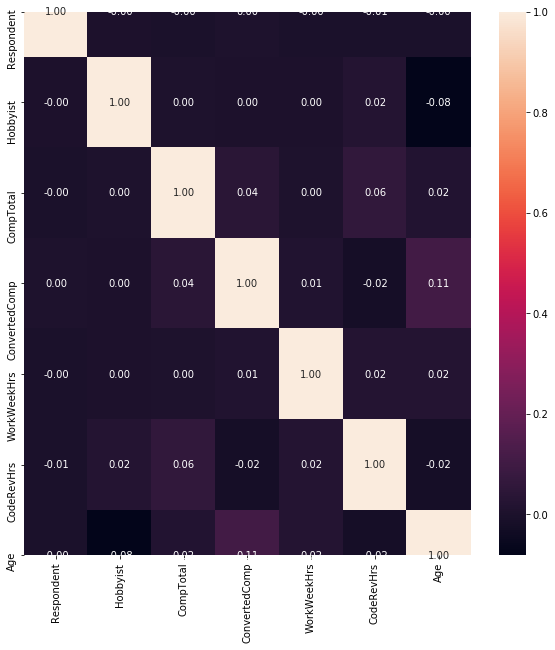

In [87]:
plt.figure(figsize=(10, 10))
sns.heatmap(df2019.corr(), annot = True, fmt = '.2f')

In [187]:
from sklearn import impute
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import visuals as vs
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [117]:
def distribution(data, enumerated, transformed):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,20));

    # Skewed feature plotting
    for i, feature in enumerate(enumerated):
        ax = fig.add_subplot(4, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

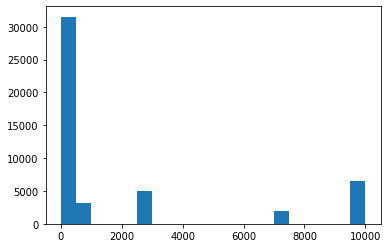

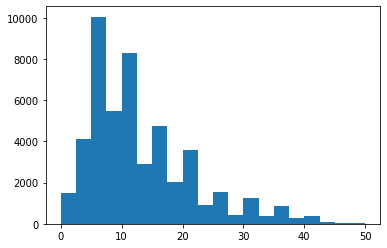

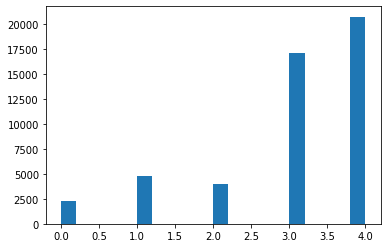

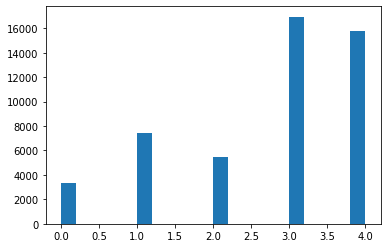

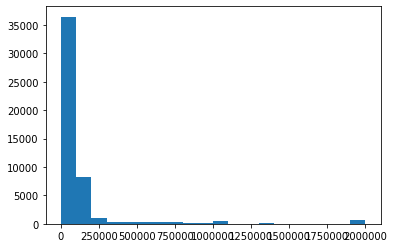

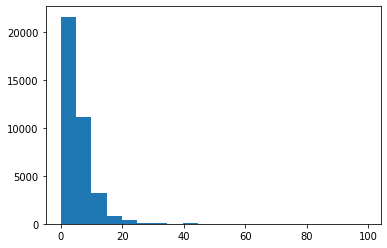

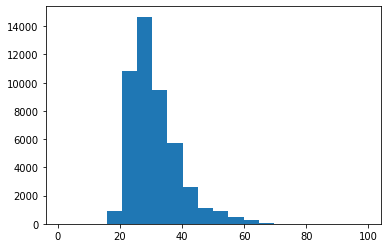

In [88]:
for col in num_feats:
    plt.hist(df19_wdummies_dropped[col], bins=20)
    plt.show()
    
#can see that all of these float features are skewed, so will log-transform them.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


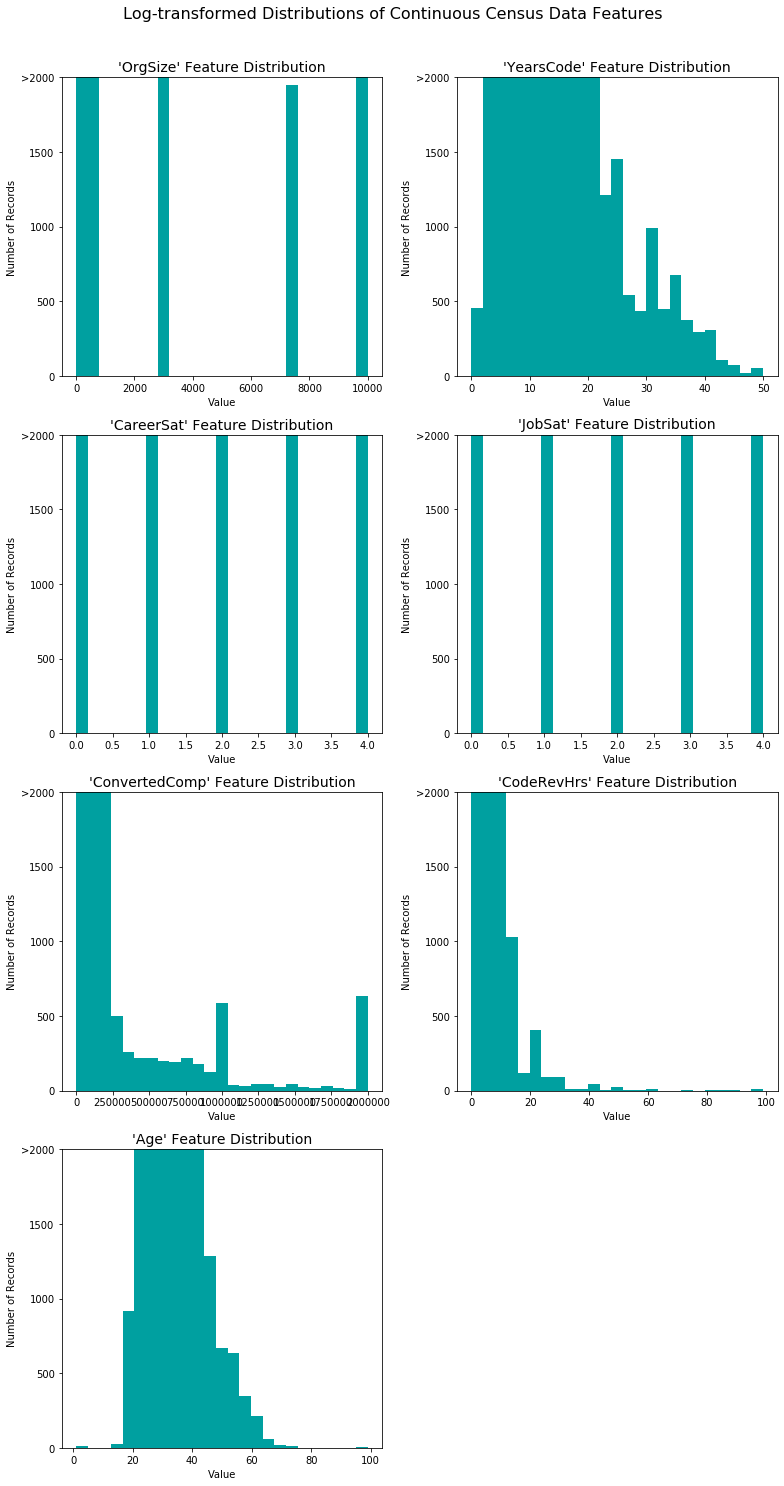

In [226]:
distribution(df19_wdummies_dropped, num_feats, transformed = True)

In [121]:
# Log-transform the skewed features
df19_wdummies_log = df19_wdummies_dropped[num_feats].apply(lambda x: np.log(x + 1))

In [138]:
scaler.fit(df19_wdummies_dropped.dropna(axis=0))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [124]:
#normalizing numerical features (feature scaling)
scaler = MinMaxScaler()
df19_log_minmax = pd.DataFrame(data = df19_wdummies_log)
df19_log_minmax[num_feats] = scaler.fit_transform(df19_log_minmax[num_feats])
display(df19_log_minmax)

OrgSize  YearsCode  CareerSat    JobSat  ConvertedComp  CodeRevHrs  \
0      0.588680   0.352583   1.000000  0.861353       0.759453         NaN   
1      0.244143   0.652356   0.861353  0.861353       0.790116    0.556972   
2      1.000000   0.652356   0.430677  0.430677       0.654442    0.349485   
3      0.244143   0.735122   1.000000  1.000000       0.786260    0.389076   
4      0.588680   0.671204   1.000000  1.000000       0.754851    0.349485   
...         ...        ...        ...       ...            ...         ...   
48983  0.401269   0.494913   0.861353  0.430677       0.767692    0.150515   
48984  1.000000   0.455707   0.861353  0.682606       0.669337         NaN   
48985  0.147085   0.748873   0.861353  1.000000       0.748047    0.238561   
48986  1.000000   0.494913   0.861353  0.861353       1.000000         NaN   
48987  1.000000   0.671204   0.861353  0.430677       0.930411         NaN   

            Age  
0      0.624318  
1      0.635197  
2           NaN  
3      0.683572  
4      0.708735  
...         ...  
48983  0.700620  
48984  0.655658  
48985  0.683572  
48986  0.645632  
48987  0.692238  

[48988 rows x 7 columns]

In [511]:
#df19_scaled = pd.DataFrame(scaler.transform(df19_wdummies_dropped), 
#                           columns = df19_wdummies_dropped.columns)

In [130]:
df19_tf_merged = df19_wdummies_dropped.copy()

In [131]:
df19_tf_merged[num_feats] = df19_log_minmax[num_feats]

In [132]:
df19_tf_merged

OrgSize  YearsCode  CareerSat    JobSat  ConvertedComp  CodeRevHrs  \
0      0.588680   0.352583   1.000000  0.861353       0.759453         NaN   
1      0.244143   0.652356   0.861353  0.861353       0.790116    0.556972   
2      1.000000   0.652356   0.430677  0.430677       0.654442    0.349485   
3      0.244143   0.735122   1.000000  1.000000       0.786260    0.389076   
4      0.588680   0.671204   1.000000  1.000000       0.754851    0.349485   
...         ...        ...        ...       ...            ...         ...   
48983  0.401269   0.494913   0.861353  0.430677       0.767692    0.150515   
48984  1.000000   0.455707   0.861353  0.682606       0.669337         NaN   
48985  0.147085   0.748873   0.861353  1.000000       0.748047    0.238561   
48986  1.000000   0.494913   0.861353  0.861353       1.000000         NaN   
48987  1.000000   0.671204   0.861353  0.430677       0.930411         NaN   

            Age  Completed an industry certification program (e.g. MCPD)  \
0      0.624318                                                  0         
1      0.635197                                                  0         
2           NaN                                                  0         
3      0.683572                                                  1         
4      0.708735                                                  0         
...         ...                                                ...         
48983  0.700620                                                  1         
48984  0.655658                                                  0         
48985  0.683572                                                  0         
48986  0.645632                                                  0         
48987  0.692238                                                  0         

       Contributed to open source software  \
0                                        0   
1                                        1   
2                                        1   
3                                        1   
4                                        0   
...                                    ...   
48983                                    1   
48984                                    0   
48985                                    1   
48986                                    0   
48987                                    1   

       Participated in a full-time developer training program or bootcamp  \
0                                                      0                    
1                                                      1                    
2                                                      0                    
3                                                      0                    
4                                                      0                    
...                                                  ...                    
48983                                                  0                    
48984                                                  0                    
48985                                                  0                    
48986                                                  0                    
48987                                                  0                    

       Participated in a hackathon  \
0                                0   
1                                0   
2                                1   
3                                0   
4                                0   
...                            ...   
48983                            0   
48984                            0   
48985                            0   
48986                            0   
48987                            0   

       Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)  \
0                                                      0                                  
1                                        

In [129]:
imputer = SimpleImputer(missing_values = np.nan,  
                        strategy ='mean')

In [135]:
imputer = imputer.fit(df19_tf_merged)

In [228]:
impupter_no_tf = imputer.fit(df19_wdummies_dropped)
df19_imputed_no_tf = pd.DataFrame(impupter_no_tf.transform(df19_wdummies_dropped), columns = df19_wdummies_dropped.columns)

In [136]:
df19_imputed = pd.DataFrame(imputer.transform(df19_tf_merged), columns = df19_tf_merged.columns)

In [137]:
df19_imputed

OrgSize  YearsCode  CareerSat    JobSat  ConvertedComp  CodeRevHrs  \
0      0.588680   0.352583   1.000000  0.861353       0.759453    0.343204   
1      0.244143   0.652356   0.861353  0.861353       0.790116    0.556972   
2      1.000000   0.652356   0.430677  0.430677       0.654442    0.349485   
3      0.244143   0.735122   1.000000  1.000000       0.786260    0.389076   
4      0.588680   0.671204   1.000000  1.000000       0.754851    0.349485   
...         ...        ...        ...       ...            ...         ...   
48983  0.401269   0.494913   0.861353  0.430677       0.767692    0.150515   
48984  1.000000   0.455707   0.861353  0.682606       0.669337    0.343204   
48985  0.147085   0.748873   0.861353  1.000000       0.748047    0.238561   
48986  1.000000   0.494913   0.861353  0.861353       1.000000    0.343204   
48987  1.000000   0.671204   0.861353  0.430677       0.930411    0.343204   

            Age  Completed an industry certification program (e.g. MCPD)  \
0      0.624318                                                0.0         
1      0.635197                                                0.0         
2      0.703289                                                0.0         
3      0.683572                                                1.0         
4      0.708735                                                0.0         
...         ...                                                ...         
48983  0.700620                                                1.0         
48984  0.655658                                                0.0         
48985  0.683572                                                0.0         
48986  0.645632                                                0.0         
48987  0.692238                                                0.0         

       Contributed to open source software  \
0                                      0.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      0.0   
...                                    ...   
48983                                  1.0   
48984                                  0.0   
48985                                  1.0   
48986                                  0.0   
48987                                  1.0   

       Participated in a full-time developer training program or bootcamp  \
0                                                    0.0                    
1                                                    1.0                    
2                                                    0.0                    
3                                                    0.0                    
4                                                    0.0                    
...                                                  ...                    
48983                                                0.0                    
48984                                                0.0                    
48985                                                0.0                    
48986                                                0.0                    
48987                                                0.0                    

       Participated in a hackathon  \
0                              0.0   
1                              0.0   
2                              1.0   
3                              0.0   
4                              0.0   
...                            ...   
48983                          0.0   
48984                          0.0   
48985                          0.0   
48986                          0.0   
48987                          0.0   

       Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)  \
0                                                    0.0                                  
1                                        

In [229]:
df19_imputed.to_csv('./df19_processed_tf.csv')
df19_imputed_no_tf.to_csv('./df19_processed_no_tf.csv')

# Linear Regression with Transformed Data

In [154]:
df19_income = df19_imputed['ConvertedComp'] #income
y = df19_income

In [155]:
df19_feats = df19_imputed.drop('ConvertedComp', axis = 1)
X = df19_feats

In [513]:
df19_income = df19_scaled['ConvertedComp']

In [525]:
X = df19_feats
y = df19_income

In [212]:
display(X, y)

OrgSize  YearsCode  CareerSat    JobSat  CodeRevHrs       Age  \
0      0.588680   0.352583   1.000000  0.861353    0.343204  0.624318   
1      0.244143   0.652356   0.861353  0.861353    0.556972  0.635197   
2      1.000000   0.652356   0.430677  0.430677    0.349485  0.703289   
3      0.244143   0.735122   1.000000  1.000000    0.389076  0.683572   
4      0.588680   0.671204   1.000000  1.000000    0.349485  0.708735   
...         ...        ...        ...       ...         ...       ...   
48983  0.401269   0.494913   0.861353  0.430677    0.150515  0.700620   
48984  1.000000   0.455707   0.861353  0.682606    0.343204  0.655658   
48985  0.147085   0.748873   0.861353  1.000000    0.238561  0.683572   
48986  1.000000   0.494913   0.861353  0.861353    0.343204  0.645632   
48987  1.000000   0.671204   0.861353  0.430677    0.343204  0.692238   

       Completed an industry certification program (e.g. MCPD)  \
0                                                    0.0         
1                                                    0.0         
2                                                    0.0         
3                                                    1.0         
4                                                    0.0         
...                                                  ...         
48983                                                1.0         
48984                                                0.0         
48985                                                0.0         
48986                                                0.0         
48987                                                0.0         

       Contributed to open source software  \
0                                      0.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      0.0   
...                                    ...   
48983                                  1.0   
48984                                  0.0   
48985                                  1.0   
48986                                  0.0   
48987                                  1.0   

       Participated in a full-time developer training program or bootcamp  \
0                                                    0.0                    
1                                                    1.0                    
2                                                    0.0                    
3                                                    0.0                    
4                                                    0.0                    
...                                                  ...                    
48983                                                0.0                    
48984                                                0.0                    
48985                                                0.0                    
48986                                                0.0                    
48987                                                0.0                    

       Participated in a hackathon  \
0                              0.0   
1                              0.0   
2                              1.0   
3                              0.0   
4                              0.0   
...                            ...   
48983                          0.0   
48984                          0.0   
48985                          0.0   
48986                          0.0   
48987                          0.0   

       Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)  \
0                                                    0.0                                  
1                                                    1.0                                  
2                                                    1.0                                  
3                                      

0        0.759453
1        0.790116
2        0.654442
3        0.786260
4        0.754851
           ...   
48983    0.767692
48984    0.669337
48985    0.748047
48986    1.000000
48987    0.930411
Name: ConvertedComp, Length: 48988, dtype: float64

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 39190 samples.
Testing set has 9798 samples.


In [218]:
display(X_train, X_test, y_train, y_test)

OrgSize  YearsCode  CareerSat    JobSat  CodeRevHrs       Age  \
3382   0.588680   0.609868   0.000000  0.000000    0.150515  0.645632   
46102  0.401269   0.774328   0.861353  0.861353    0.343204  0.772088   
15653  0.858671   0.774328   1.000000  1.000000    0.349485  0.752664   
8439   1.000000   0.774328   1.000000  1.000000    0.349485  0.759304   
35212  0.549040   0.455707   0.430677  0.430677    0.238561  0.645632   
...         ...        ...        ...       ...         ...       ...   
21243  0.696026   0.558831   0.861353  0.430677    0.150515  0.635197   
45891  0.000000   0.748873   1.000000  1.000000    0.343204  0.795884   
42613  0.966228   0.847495   0.000000  0.430677    0.520696  0.795884   
43567  0.401269   0.652356   0.861353  0.430677    0.238561  0.738843   
2732   0.401269   0.705166   1.000000  0.430677    0.343204  0.700620   

       Completed an industry certification program (e.g. MCPD)  \
3382                                                 0.0         
46102                                                0.0         
15653                                                0.0         
8439                                                 1.0         
35212                                                0.0         
...                                                  ...         
21243                                                1.0         
45891                                                0.0         
42613                                                0.0         
43567                                                0.0         
2732                                                 0.0         

       Contributed to open source software  \
3382                                   0.0   
46102                                  0.0   
15653                                  0.0   
8439                                   0.0   
35212                                  1.0   
...                                    ...   
21243                                  1.0   
45891                                  1.0   
42613                                  1.0   
43567                                  1.0   
2732                                   0.0   

       Participated in a full-time developer training program or bootcamp  \
3382                                                 0.0                    
46102                                                0.0                    
15653                                                0.0                    
8439                                                 0.0                    
35212                                                0.0                    
...                                                  ...                    
21243                                                0.0                    
45891                                                0.0                    
42613                                                0.0                    
43567                                                0.0                    
2732                                                 0.0                    

       Participated in a hackathon  \
3382                           1.0   
46102                          0.0   
15653                          0.0   
8439                           0.0   
35212                          0.0   
...                            ...   
21243                          0.0   
45891                          1.0   
42613                          0.0   
43567                          0.0   
2732                           0.0   

       Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)  \
3382                                                 1.0                                  
46102                                                0.0                                  
15653                                                0.0                                  
8439                                   

OrgSize  YearsCode  CareerSat    JobSat  CodeRevHrs       Age  \
24755  0.244143   0.652356   0.682606  0.682606    0.150515  0.738843   
17251  0.401269   0.585627   1.000000  1.000000    0.389076  0.601064   
15224  0.588680   0.652356   0.861353  0.861353    0.389076  0.692238   
2901   0.588680   0.748873   0.430677  0.682606    0.238561  0.759304   
13673  0.244143   0.705166   0.430677  0.861353    0.343204  0.778248   
...         ...        ...        ...       ...         ...       ...   
32023  0.966228   0.352583   1.000000  1.000000    0.343204  0.665305   
17156  0.000000   0.808290   1.000000  0.861353    0.389076  0.716601   
47812  0.588680   0.558831   0.861353  0.861353    0.301030  0.683572   
1687   0.966228   0.455707   1.000000  1.000000    0.343204  0.674602   
21453  0.549040   0.688751   1.000000  1.000000    0.389076  0.790139   

       Completed an industry certification program (e.g. MCPD)  \
24755                                                0.0         
17251                                                0.0         
15224                                                0.0         
2901                                                 0.0         
13673                                                0.0         
...                                                  ...         
32023                                                1.0         
17156                                                1.0         
47812                                                0.0         
1687                                                 0.0         
21453                                                0.0         

       Contributed to open source software  \
24755                                  0.0   
17251                                  0.0   
15224                                  0.0   
2901                                   0.0   
13673                                  1.0   
...                                    ...   
32023                                  1.0   
17156                                  0.0   
47812                                  1.0   
1687                                   0.0   
21453                                  0.0   

       Participated in a full-time developer training program or bootcamp  \
24755                                                0.0                    
17251                                                0.0                    
15224                                                0.0                    
2901                                                 0.0                    
13673                                                0.0                    
...                                                  ...                    
32023                                                0.0                    
17156                                                1.0                    
47812                                                0.0                    
1687                                                 0.0                    
21453                                                0.0                    

       Participated in a hackathon  \
24755                          0.0   
17251                          0.0   
15224                          0.0   
2901                           0.0   
13673                          0.0   
...                            ...   
32023                          1.0   
17156                          0.0   
47812                          0.0   
1687                           1.0   
21453                          1.0   

       Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)  \
24755                                                1.0                                  
17251                                                0.0                                  
15224                                                0.0                                  
2901                                   

3382     0.923531
46102    0.732484
15653    0.855284
8439     0.816713
35212    0.575008
           ...   
21243    0.773694
45891    0.758314
42613    0.778142
43567    0.746804
2732     0.661656
Name: ConvertedComp, Length: 39190, dtype: float64

24755    0.754210
17251    0.629555
15224    0.248880
2901     0.646905
13673    0.667765
           ...   
32023    0.633036
17156    0.723106
47812    0.777325
1687     0.761677
21453    0.752312
Name: ConvertedComp, Length: 9798, dtype: float64

In [219]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

    #Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [220]:
len(y_test_preds)

9798

In [221]:
y_test

24755    0.754210
17251    0.629555
15224    0.248880
2901     0.646905
13673    0.667765
           ...   
32023    0.633036
17156    0.723106
47812    0.777325
1687     0.761677
21453    0.752312
Name: ConvertedComp, Length: 9798, dtype: float64

In [222]:
reg = lm_model.fit(X_train, y_train)

In [223]:
test_score, train_score

(0.17417468435517214, 0.18304500840484816)

In [199]:
coeff_df = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficient'])  
sorted_coeff = coeff_df['Coefficient'].sort_values(ascending = False)

In [201]:
list(sorted_coeff.index)

['Age',
 'YearsCode',
 'OrgSize',
 'CareerSat',
 'JobSat',
 'Erlang',
 'F#',
 'Objective-C',
 'R',
 'Senior executive/VP',
 'Assembly',
 'Data scientist or machine learning specialist',
 'Swift',
 'Product manager',
 'PHP',
 'Database administrator',
 'Go',
 'Developer, full-stack',
 'Taken an online course in programming or software development (e.g. a MOOC)',
 'Completed an industry certification program (e.g. MCPD)',
 'Student_y',
 'Python',
 'Received on-the-job training in software development',
 'Engineer, site reliability',
 'Java',
 'C',
 'Designer',
 'Ruby',
 'Academic researcher',
 'Kotlin',
 'Contributed to open source software',
 'Developer, mobile',
 'System administrator',
 'Developer, back-end',
 'SQL',
 'Scala',
 'Clojure',
 'C#',
 'Bash/Shell/PowerShell',
 'TypeScript',
 'Developer, desktop or enterprise applications',
 'JavaScript',
 'WebAssembly',
 'Taught yourself a new language, framework, or tool without taking a formal course',
 'Rust',
 'Developer, embedded appl

In [225]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_preds})
df.head(25)

Actual  Predicted
24755  0.754210   0.733154
17251  0.629555   0.753403
15224  0.248880   0.735779
2901   0.646905   0.761749
13673  0.667765   0.743195
34988  0.815463   0.805298
28773  0.651144   0.750610
14474  0.724315   0.730057
41813  0.944963   0.696655
38343  0.816713   0.779541
5094   0.653895   0.721191
23433  0.704523   0.787857
14530  0.768266   0.739105
30277  0.624940   0.658417
17178  0.757829   0.815887
34761  0.738486   0.731583
8763   0.670529   0.656433
40264  0.707693   0.699249
11277  0.814206   0.786316
33414  0.758314   0.688080
22250  0.691698   0.743896
42740  0.745748   0.688965
42620  0.793522   0.723999
31438  0.676608   0.684052
18461  0.773694   0.762787

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline



# Linear Regression, NO transforms


In [230]:
df19_imputed_no_tf

OrgSize  YearsCode  CareerSat  JobSat  ConvertedComp  CodeRevHrs  \
0        300.0        3.0        4.0     3.0        61000.0    4.887454   
1         15.0       12.0        3.0     3.0        95179.0   12.000000   
2      10000.0       12.0        1.0     1.0        13293.0    4.000000   
3         15.0       17.0        4.0     4.0        90000.0    5.000000   
4        300.0       13.0        4.0     4.0        57060.0    4.000000   
...        ...        ...        ...     ...            ...         ...   
48983     60.0        6.0        3.0     1.0        68745.0    1.000000   
48984  10000.0        5.0        3.0     2.0        16500.0    4.887454   
48985      6.0       18.0        3.0     4.0        51696.0    2.000000   
48986  10000.0        6.0        3.0     3.0      2000000.0    4.887454   
48987  10000.0       13.0        3.0     1.0       728700.0    4.887454   

             Age  Completed an industry certification program (e.g. MCPD)  \
0      22.000000                                                0.0         
1      23.000000                                                0.0         
2      31.197241                                                0.0         
3      28.000000                                                1.0         
4      31.000000                                                0.0         
...          ...                                                ...         
48983  30.000000                                                1.0         
48984  25.000000                                                0.0         
48985  28.000000                                                0.0         
48986  24.000000                                                0.0         
48987  29.000000                                                0.0         

       Contributed to open source software  \
0                                      0.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      0.0   
...                                    ...   
48983                                  1.0   
48984                                  0.0   
48985                                  1.0   
48986                                  0.0   
48987                                  1.0   

       Participated in a full-time developer training program or bootcamp  \
0                                                    0.0                    
1                                                    1.0                    
2                                                    0.0                    
3                                                    0.0                    
4                                                    0.0                    
...                                                  ...                    
48983                                                0.0                    
48984                                                0.0                    
48985                                                0.0                    
48986                                                0.0                    
48987                                                0.0                    

       Participated in a hackathon  \
0                              0.0   
1                              0.0   
2                              1.0   
3                              0.0   
4                              0.0   
...                            ...   
48983                          0.0   
48984                          0.0   
48985                          0.0   
48986                          0.0   
48987                          0.0   

       Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)  \
0                                                    0.0                                  
1                                                    1.0        

In [232]:
df19_income_no_tf = df19_imputed_no_tf['ConvertedComp'] #income
y2 = df19_income_no_tf

In [233]:
df19_feats_no_tf = df19_imputed_no_tf.drop('ConvertedComp', axis = 1)
X2 = df19_feats_no_tf

In [513]:
df19_income = df19_scaled['ConvertedComp']

In [235]:
display(X2, y2)

OrgSize  YearsCode  CareerSat  JobSat  CodeRevHrs        Age  \
0        300.0        3.0        4.0     3.0    4.887454  22.000000   
1         15.0       12.0        3.0     3.0   12.000000  23.000000   
2      10000.0       12.0        1.0     1.0    4.000000  31.197241   
3         15.0       17.0        4.0     4.0    5.000000  28.000000   
4        300.0       13.0        4.0     4.0    4.000000  31.000000   
...        ...        ...        ...     ...         ...        ...   
48983     60.0        6.0        3.0     1.0    1.000000  30.000000   
48984  10000.0        5.0        3.0     2.0    4.887454  25.000000   
48985      6.0       18.0        3.0     4.0    2.000000  28.000000   
48986  10000.0        6.0        3.0     3.0    4.887454  24.000000   
48987  10000.0       13.0        3.0     1.0    4.887454  29.000000   

       Completed an industry certification program (e.g. MCPD)  \
0                                                    0.0         
1                                                    0.0         
2                                                    0.0         
3                                                    1.0         
4                                                    0.0         
...                                                  ...         
48983                                                1.0         
48984                                                0.0         
48985                                                0.0         
48986                                                0.0         
48987                                                0.0         

       Contributed to open source software  \
0                                      0.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      0.0   
...                                    ...   
48983                                  1.0   
48984                                  0.0   
48985                                  1.0   
48986                                  0.0   
48987                                  1.0   

       Participated in a full-time developer training program or bootcamp  \
0                                                    0.0                    
1                                                    1.0                    
2                                                    0.0                    
3                                                    0.0                    
4                                                    0.0                    
...                                                  ...                    
48983                                                0.0                    
48984                                                0.0                    
48985                                                0.0                    
48986                                                0.0                    
48987                                                0.0                    

       Participated in a hackathon  \
0                              0.0   
1                              0.0   
2                              1.0   
3                              0.0   
4                              0.0   
...                            ...   
48983                          0.0   
48984                          0.0   
48985                          0.0   
48986                          0.0   
48987                          0.0   

       Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)  \
0                                                    0.0                                  
1                                                    1.0                                  
2                                                    1.0                                  
3                                                    0.0      

0          61000.0
1          95179.0
2          13293.0
3          90000.0
4          57060.0
           ...    
48983      68745.0
48984      16500.0
48985      51696.0
48986    2000000.0
48987     728700.0
Name: ConvertedComp, Length: 48988, dtype: float64

In [236]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 
                                                    y2, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 39190 samples.
Testing set has 9798 samples.


In [237]:
lm_model2 = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X2_train, y2_train) #Fit

    #Predict using your model
y2_test_preds = lm_model.predict(X2_test)
y2_train_preds = lm_model.predict(X2_train)

    #Score using your model
test2_score = r2_score(y2_test, y2_test_preds)
train2_score = r2_score(y2_train, y2_train_preds)

In [238]:
test2_score, train2_score

(0.025563535590127806, 0.030120541255325817)

In [220]:
len(y2_test_preds)

9798

In [221]:
y2_test

24755    0.754210
17251    0.629555
15224    0.248880
2901     0.646905
13673    0.667765
           ...   
32023    0.633036
17156    0.723106
47812    0.777325
1687     0.761677
21453    0.752312
Name: ConvertedComp, Length: 9798, dtype: float64

In [222]:
reg2 = lm_model.fit(X2_train, y2_train)

In [199]:
coeff_df = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficient'])  
sorted_coeff = coeff_df['Coefficient'].sort_values(ascending = False)

In [201]:
list(sorted_coeff.index)

['Age',
 'YearsCode',
 'OrgSize',
 'CareerSat',
 'JobSat',
 'Erlang',
 'F#',
 'Objective-C',
 'R',
 'Senior executive/VP',
 'Assembly',
 'Data scientist or machine learning specialist',
 'Swift',
 'Product manager',
 'PHP',
 'Database administrator',
 'Go',
 'Developer, full-stack',
 'Taken an online course in programming or software development (e.g. a MOOC)',
 'Completed an industry certification program (e.g. MCPD)',
 'Student_y',
 'Python',
 'Received on-the-job training in software development',
 'Engineer, site reliability',
 'Java',
 'C',
 'Designer',
 'Ruby',
 'Academic researcher',
 'Kotlin',
 'Contributed to open source software',
 'Developer, mobile',
 'System administrator',
 'Developer, back-end',
 'SQL',
 'Scala',
 'Clojure',
 'C#',
 'Bash/Shell/PowerShell',
 'TypeScript',
 'Developer, desktop or enterprise applications',
 'JavaScript',
 'WebAssembly',
 'Taught yourself a new language, framework, or tool without taking a formal course',
 'Rust',
 'Developer, embedded appl

In [239]:
df2 = pd.DataFrame({'Actual': y2_test, 'Predicted': y2_test_preds})
df2.head(25)

Actual  Predicted
24755   56532.0    80640.0
17251    9264.0   161664.0
15224      36.0    93568.0
2901    11916.0   105856.0
13673   16128.0   119424.0
34988  137484.0   206592.0
28773   12672.0   147456.0
14474   36637.0    82304.0
41813  900000.0    97408.0
38343  140000.0   167552.0
5094    13188.0    97152.0
23433   27492.0   193280.0
14530   69320.0   162368.0
30277    8664.0     5504.0
17178   59579.0   201088.0
34761   45000.0   146688.0
8763    16788.0    22400.0
40264   28786.0   123648.0
11277  135000.0   197504.0
33414   60000.0   103808.0
22250   22824.0   103936.0
42740   50000.0    70784.0
42620  100000.0    94080.0
31438   18336.0    66048.0
18461   75000.0   101888.0

In [ ]:
df19_imputed.to_csv('./df19_processed_merged')

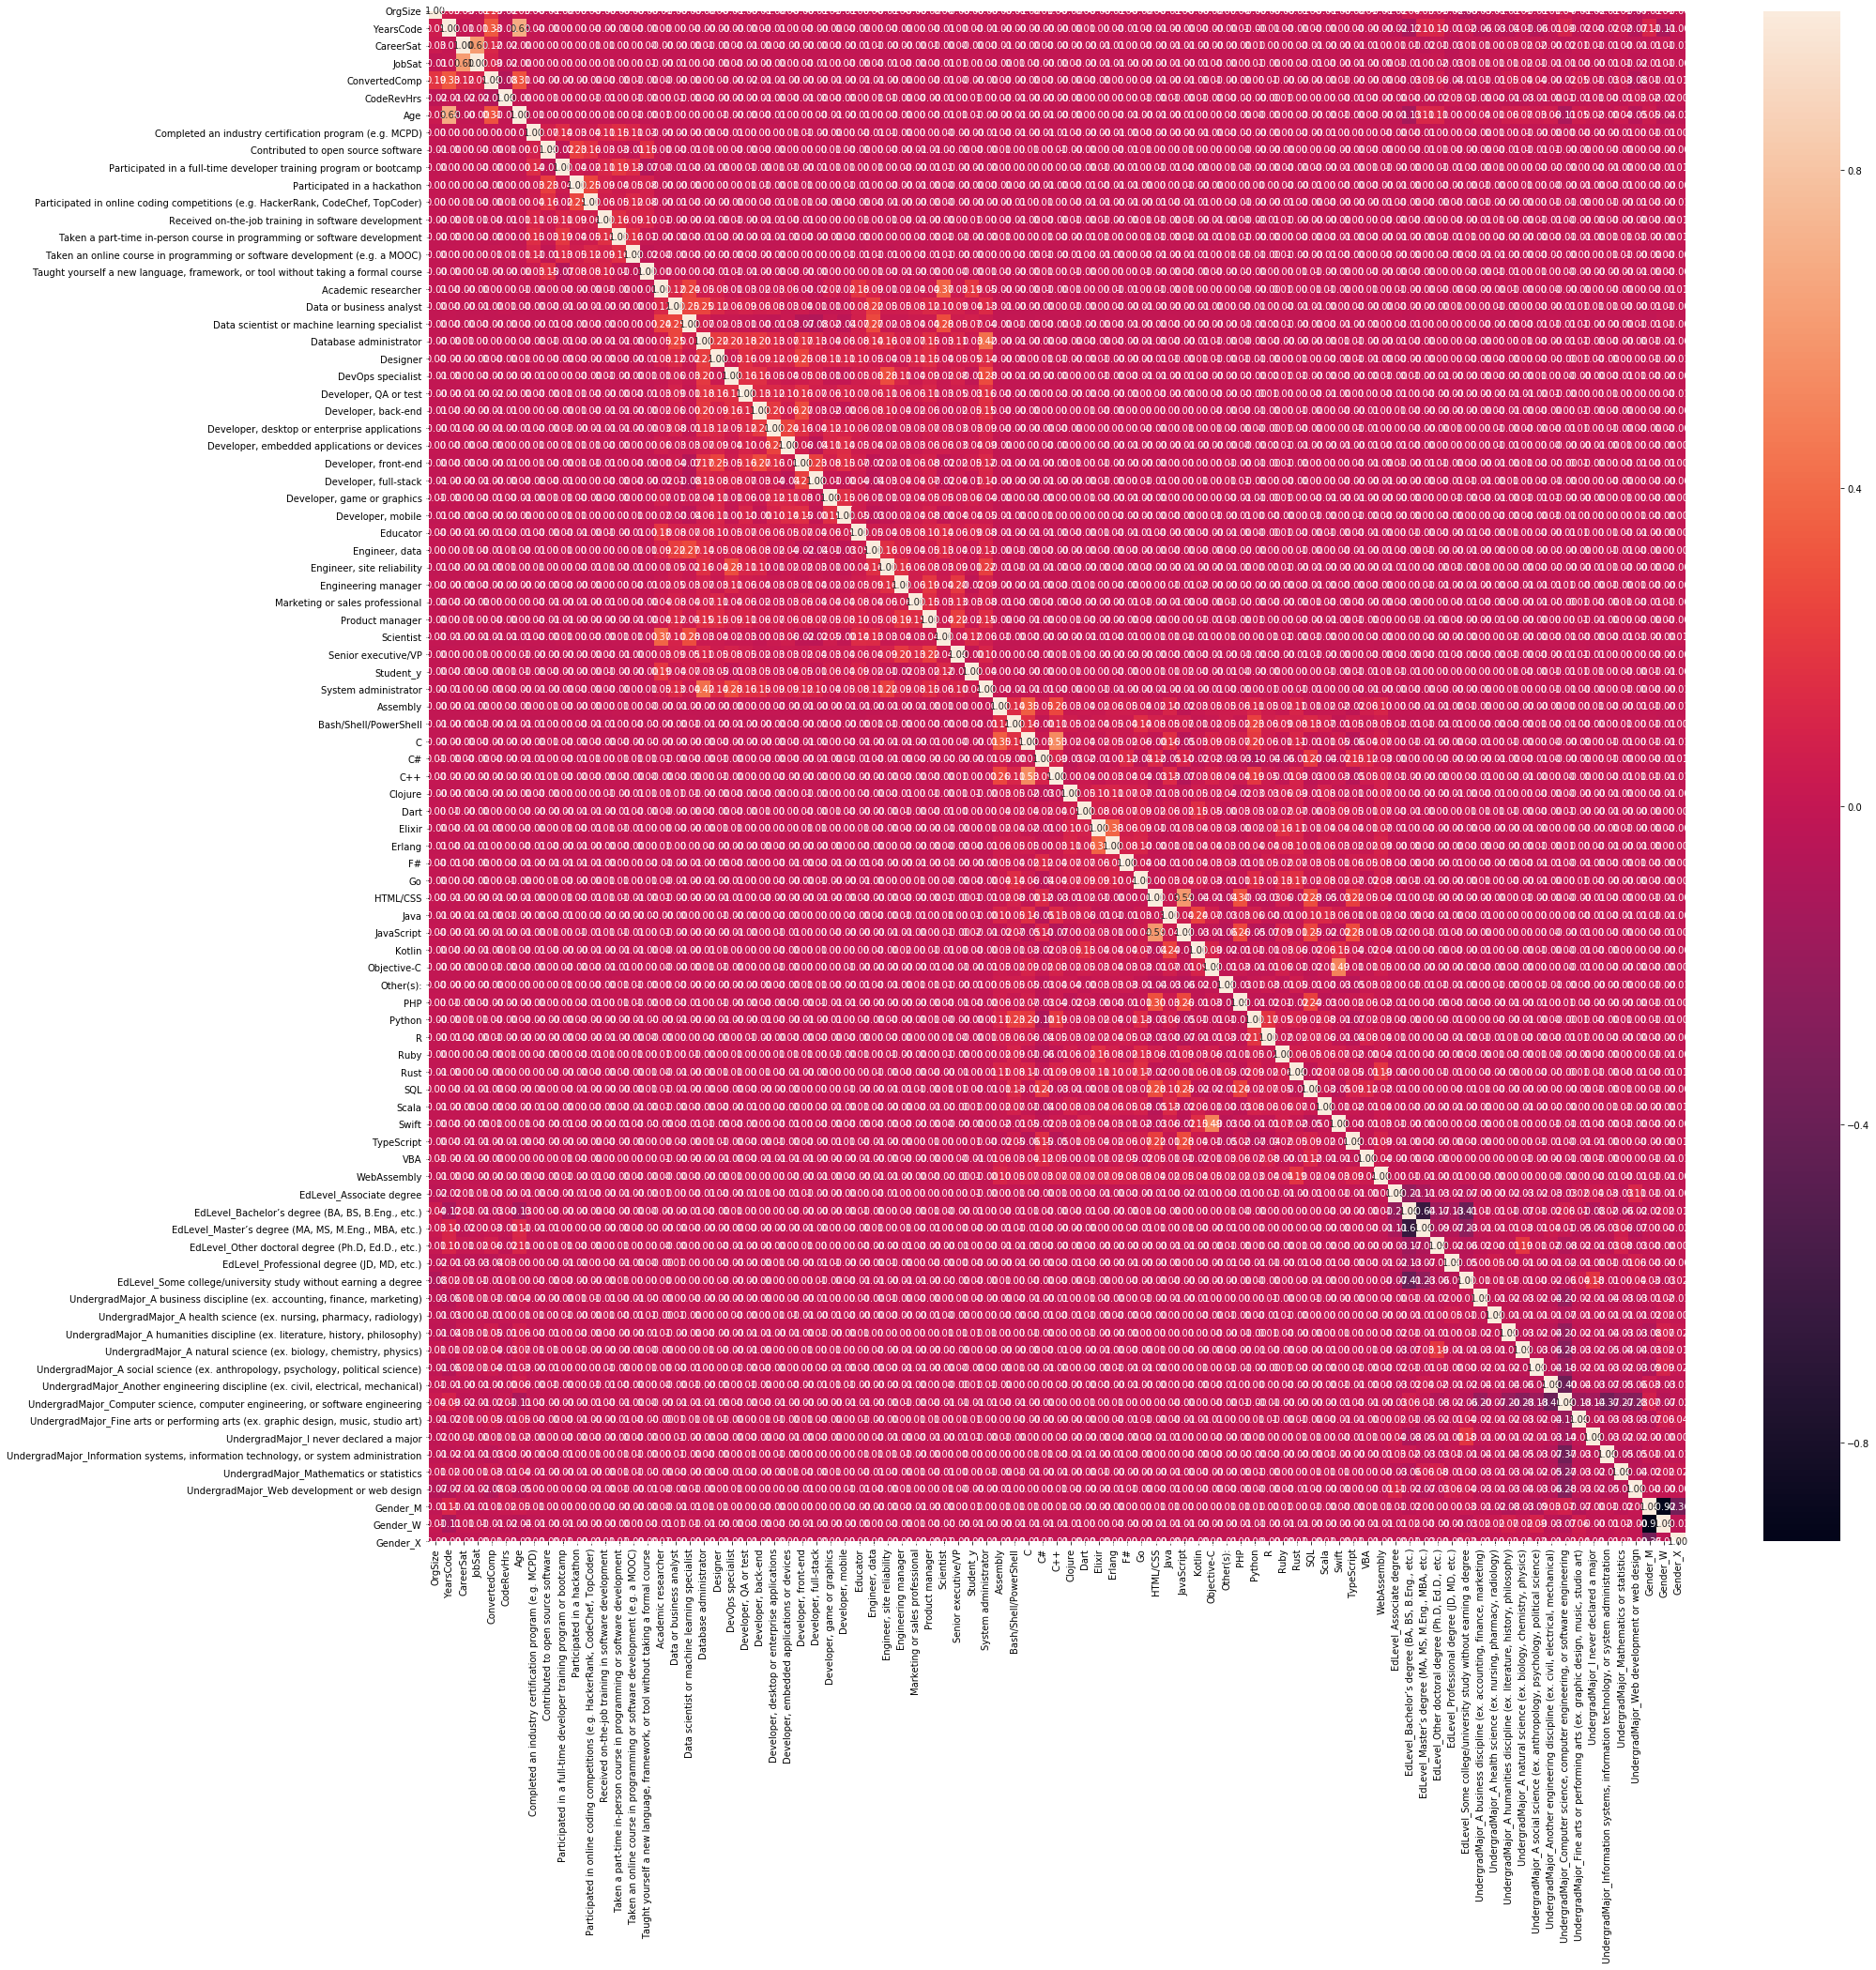

In [183]:

plt.figure(figsize=(40, 40))
sns.heatmap(df19_imputed.corr(), annot = True, fmt = '.2f')

In [204]:
col_list

['Respondent',
 'MainBranch',
 'Hobbyist',
 'OpenSourcer',
 'OpenSource',
 'Employment',
 'Country',
 'Student',
 'EdLevel',
 'UndergradMajor',
 'EduOther',
 'OrgSize',
 'DevType',
 'YearsCode',
 'Age1stCode',
 'YearsCodePro',
 'CareerSat',
 'JobSat',
 'MgrIdiot',
 'MgrMoney',
 'MgrWant',
 'JobSeek',
 'LastHireDate',
 'LastInt',
 'FizzBuzz',
 'JobFactors',
 'ResumeUpdate',
 'CurrencySymbol',
 'CurrencyDesc',
 'CompTotal',
 'CompFreq',
 'ConvertedComp',
 'WorkWeekHrs',
 'WorkPlan',
 'WorkChallenge',
 'WorkRemote',
 'WorkLoc',
 'ImpSyn',
 'CodeRev',
 'CodeRevHrs',
 'UnitTests',
 'PurchaseHow',
 'PurchaseWhat',
 'LanguageWorkedWith',
 'LanguageDesireNextYear',
 'DatabaseWorkedWith',
 'DatabaseDesireNextYear',
 'PlatformWorkedWith',
 'PlatformDesireNextYear',
 'WebFrameWorkedWith',
 'WebFrameDesireNextYear',
 'MiscTechWorkedWith',
 'MiscTechDesireNextYear',
 'DevEnviron',
 'OpSys',
 'Containers',
 'BlockchainIs',
 'BetterLife',
 'ITperson',
 'OffOn',
 'SocialMedia',
 'Extraversion',
 'Scre

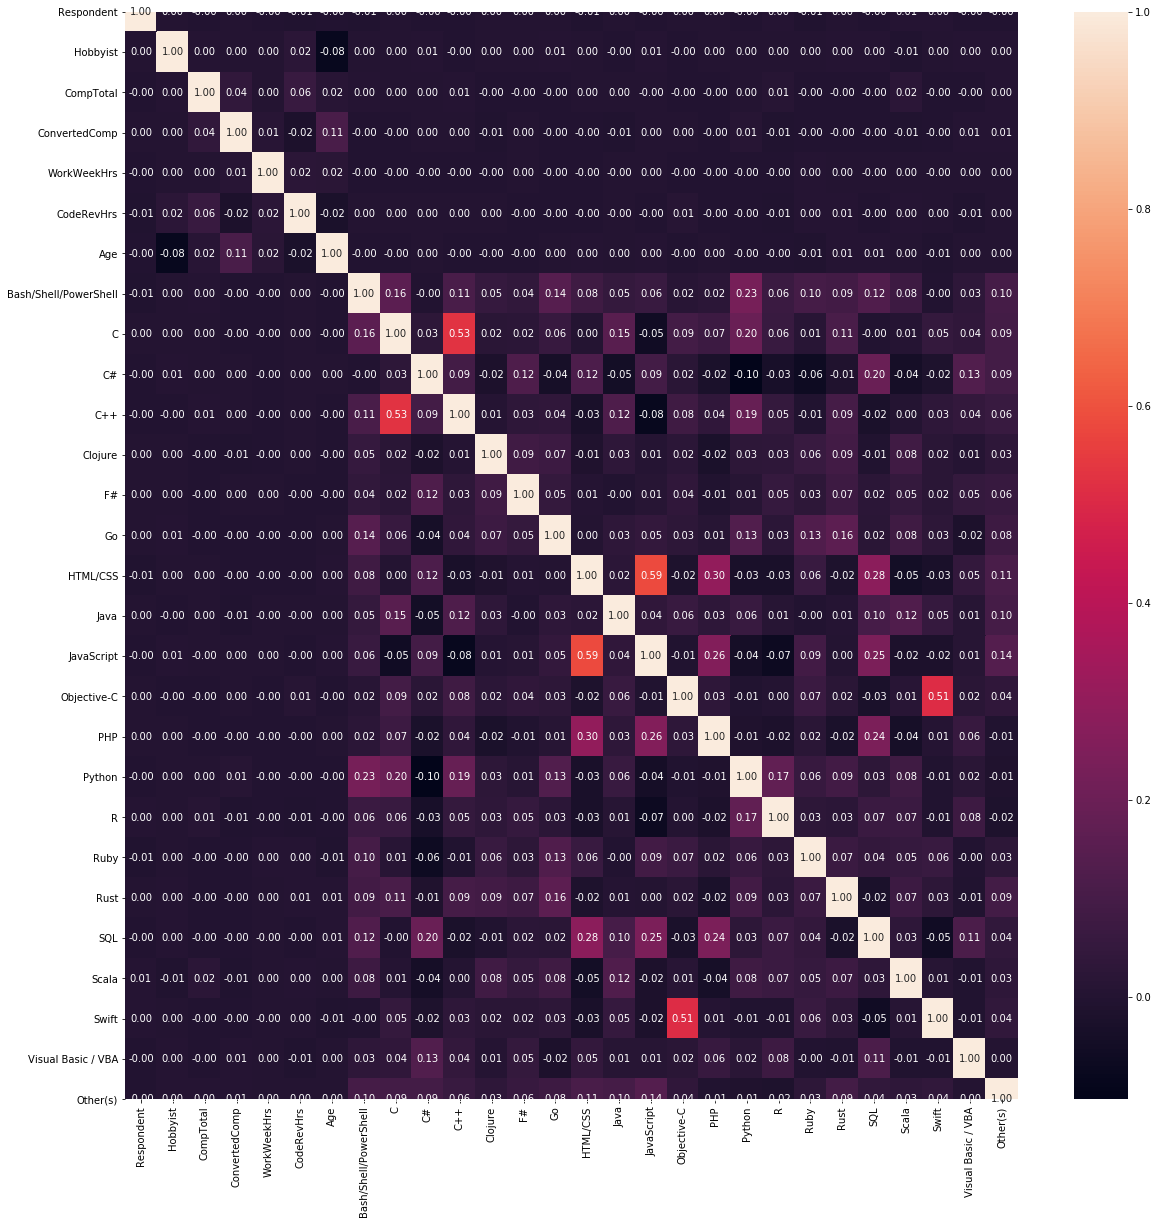

In [200]:
plt.figure(figsize=(20, 20))
sns.heatmap(merged_df19.corr(), annot = True, fmt = '.2f')

---
# <center>2015 Dataset
---

In [124]:
#slicing the desired columns about Current Lang & Tech from the rest of the 2015 df
#modify new df column names to match list
df2015_mix = df2015.loc[:,'Current Lang & Tech: Android':'Current Lang & Tech: Write-In']
df2015_mix.columns = df2015_mix.columns.str.replace('Current Lang & Tech: ', '')
#df2015_mix.columns = df2015_mix.columns.str.casefold()

In [125]:
#take a look
display(df2015_mix.info(),
     df2015_mix.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26086 entries, 0 to 26085
Data columns (total 43 columns):
Android          4110 non-null object
Arduino          1626 non-null object
AngularJS        2913 non-null object
C                3612 non-null object
C++              4529 non-null object
C++11            1851 non-null object
C#               6949 non-null object
Cassandra        202 non-null object
CoffeeScript     783 non-null object
Cordova          628 non-null object
Clojure          176 non-null object
Cloud            1410 non-null object
Dart             109 non-null object
F#               174 non-null object
Go               462 non-null object
Hadoop           342 non-null object
Haskell          357 non-null object
iOS              1956 non-null object
Java             8219 non-null object
JavaScript       11962 non-null object
LAMP             1926 non-null object
Matlab           860 non-null object
MongoDB          1745 non-null object
Node.js          2919 non-

None

Android Arduino AngularJS    C  C++ C++11   C# Cassandra CoffeeScript  \
0     NaN     NaN       NaN  NaN  NaN   NaN  NaN       NaN          NaN   
1     NaN     NaN       NaN  NaN  NaN   NaN   C#       NaN          NaN   
2     NaN     NaN       NaN  NaN  NaN   NaN   C#       NaN          NaN   
3     NaN     NaN       NaN  NaN  NaN   NaN  NaN       NaN          NaN   
4     NaN     NaN       NaN  NaN  NaN   NaN   C#       NaN          NaN   

  Cordova Clojure Cloud Dart   F#   Go Hadoop Haskell  iOS  Java  JavaScript  \
0     NaN     NaN   NaN  NaN  NaN  NaN    NaN     NaN  NaN  Java         NaN   
1     NaN     NaN   NaN  NaN  NaN  NaN    NaN     NaN  NaN   NaN         NaN   
2     NaN     NaN   NaN  NaN  NaN  NaN    NaN     NaN  NaN   NaN         NaN   
3     NaN     NaN   NaN  NaN  NaN  NaN    NaN     NaN  NaN   NaN  JavaScript   
4     NaN     NaN   NaN  NaN  NaN   Go    NaN     NaN  NaN   NaN         NaN   

   LAMP Matlab MongoDB  Node.js Objective-C Perl  PHP  Python    R  Redis  \
0   NaN    NaN     NaN      NaN         NaN  NaN  NaN     NaN  NaN    NaN   
1   NaN    NaN     NaN      NaN         NaN  NaN  NaN     NaN  NaN    NaN   
2   NaN    NaN     NaN      NaN         NaN  NaN  NaN     NaN  NaN    NaN   
3  LAMP    NaN     NaN  Node.js         NaN  NaN  PHP  Python  NaN  Redis   
4   NaN    NaN     NaN      NaN         NaN  NaN  NaN     NaN  NaN    NaN   

  Ruby Rust Salesforce  Scala Sharepoint Spark  SQL SQL Server Swift  \
0  NaN  NaN        NaN  Scala        NaN   NaN  NaN        NaN   NaN   
1  NaN  NaN        NaN    NaN        NaN   NaN  NaN        NaN   NaN   
2  NaN  NaN        NaN    NaN        NaN   NaN  NaN        NaN   NaN   
3  NaN  NaN        NaN    NaN        NaN   NaN  SQL        NaN   NaN   
4  NaN  NaN        NaN    NaN        NaN   NaN  NaN        NaN   NaN   

  Visual Basic Windows Phone Wordpress Write-In  
0          NaN           NaN       NaN      NaN  
1          NaN           NaN       NaN      NaN  
2          NaN           NaN       NaN      NaN  
3          NaN           NaN       NaN      lua  
4          NaN           NaN       NaN      NaN

In [126]:
#drop non-language columns
dflang2015 = clean_df_cat(df2015_mix, not_lang_list)

#check that the removal was successful:
print(df2015_mix.shape, dflang2015.shape)

(26086, 43) (26086, 24)


In [127]:
#drop empty rows
dflang2015 = dflang2015[dflang2015.count(axis = 1) > 0]
lang2015_len = dflang2015.shape[0]
lang2015_len

21739

In [128]:
dflang2015 = dflang2015.rename(columns = {"C++": "C++_ini", 
                                "Visual Basic": "Visual Basic / VBA"})
dflang2015.head()

C C++_ini C++11   C# CoffeeScript Clojure Dart   F#   Go Haskell  Java  \
0  NaN     NaN   NaN  NaN          NaN     NaN  NaN  NaN  NaN     NaN  Java   
1  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
2  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
3  NaN     NaN   NaN  NaN          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
4  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN   Go     NaN   NaN   

   JavaScript Matlab Objective-C Perl  PHP  Python    R Ruby Rust  Scala  SQL  \
0         NaN    NaN         NaN  NaN  NaN     NaN  NaN  NaN  NaN  Scala  NaN   
1         NaN    NaN         NaN  NaN  NaN     NaN  NaN  NaN  NaN    NaN  NaN   
2         NaN    NaN         NaN  NaN  NaN     NaN  NaN  NaN  NaN    NaN  NaN   
3  JavaScript    NaN         NaN  NaN  PHP  Python  NaN  NaN  NaN    NaN  SQL   
4         NaN    NaN         NaN  NaN  NaN     NaN  NaN  NaN  NaN    NaN  NaN   

  Swift Visual Basic / VBA  
0   NaN                NaN  
1   NaN                NaN  
2   NaN                NaN  
3   NaN                NaN  
4   NaN                NaN

In [129]:
#make the new column 'C++' with booleans
dflang2015['C++'] = ((dflang2015['C++_ini'].isnull() == 0) | 
                             (dflang2015['C++11'].isnull() == 0)).astype(dtype = 'int')
dflang2015['C++'] = dflang2015['C++'].replace(0, np.nan)

In [130]:
dflang2015.head(n = 10)

C C++_ini C++11   C# CoffeeScript Clojure Dart   F#   Go Haskell  Java  \
0  NaN     NaN   NaN  NaN          NaN     NaN  NaN  NaN  NaN     NaN  Java   
1  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
2  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
3  NaN     NaN   NaN  NaN          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
4  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN   Go     NaN   NaN   
5  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
6  NaN     NaN   NaN  NaN          NaN     NaN  NaN  NaN  NaN     NaN  Java   
7  NaN     NaN   NaN  NaN          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
8  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN   
9  NaN     NaN   NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN   

   JavaScript Matlab Objective-C Perl  PHP  Python    R  Ruby Rust  Scala  \
0         NaN    NaN         NaN  NaN  NaN     NaN  NaN   NaN  NaN  Scala   
1         NaN    NaN         NaN  NaN  NaN     NaN  NaN   NaN  NaN    NaN   
2         NaN    NaN         NaN  NaN  NaN     NaN  NaN   NaN  NaN    NaN   
3  JavaScript    NaN         NaN  NaN  PHP  Python  NaN   NaN  NaN    NaN   
4         NaN    NaN         NaN  NaN  NaN     NaN  NaN   NaN  NaN    NaN   
5  JavaScript    NaN         NaN  NaN  NaN     NaN  NaN   NaN  NaN    NaN   
6  JavaScript    NaN         NaN  NaN  PHP     NaN  NaN   NaN  NaN    NaN   
7  JavaScript    NaN         NaN  NaN  NaN  Python  NaN  Ruby  NaN    NaN   
8  JavaScript    NaN         NaN  NaN  NaN     NaN  NaN   NaN  NaN    NaN   
9         NaN    NaN         NaN  NaN  PHP     NaN  NaN   NaN  NaN    NaN   

   SQL Swift Visual Basic / VBA  C++  
0  NaN   NaN                NaN  NaN  
1  NaN   NaN                NaN  NaN  
2  NaN   NaN                NaN  NaN  
3  SQL   NaN                NaN  NaN  
4  NaN   NaN                NaN  NaN  
5  NaN   NaN                NaN  NaN  
6  SQL   NaN                NaN  NaN  
7  SQL   NaN                NaN  NaN  
8  NaN   NaN                NaN  NaN  
9  NaN   NaN                NaN  NaN

In [131]:
#double-checking that the new boolean column is correct
print(dflang2015['C++_ini'].count(), 
dflang2015['C++11'].count(),
dflang2015['C++'].count())
dflang2015.loc[:,('C++_ini', 'C++11', 'C++')].reindex().head(n=50)

4529 1851 4840


C++_ini C++11  C++
0      NaN   NaN  NaN
1      NaN   NaN  NaN
2      NaN   NaN  NaN
3      NaN   NaN  NaN
4      NaN   NaN  NaN
..     ...   ...  ...
46     NaN   NaN  NaN
47     NaN   NaN  NaN
48     C++   NaN  1.0
49     NaN   NaN  NaN
50     NaN   NaN  NaN

[50 rows x 3 columns]

In [132]:
#take out the now defunct initial C++ column and C++11 column, 
#since they will affect the next fxn
dflang2015 = dflang2015.drop(['C++_ini', 'C++11'], axis = 1)
dflang2015.head()

C   C# CoffeeScript Clojure Dart   F#   Go Haskell  Java  JavaScript  \
0  NaN  NaN          NaN     NaN  NaN  NaN  NaN     NaN  Java         NaN   
1  NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN         NaN   
2  NaN   C#          NaN     NaN  NaN  NaN  NaN     NaN   NaN         NaN   
3  NaN  NaN          NaN     NaN  NaN  NaN  NaN     NaN   NaN  JavaScript   
4  NaN   C#          NaN     NaN  NaN  NaN   Go     NaN   NaN         NaN   

  Matlab Objective-C Perl  PHP  Python    R Ruby Rust  Scala  SQL Swift  \
0    NaN         NaN  NaN  NaN     NaN  NaN  NaN  NaN  Scala  NaN   NaN   
1    NaN         NaN  NaN  NaN     NaN  NaN  NaN  NaN    NaN  NaN   NaN   
2    NaN         NaN  NaN  NaN     NaN  NaN  NaN  NaN    NaN  NaN   NaN   
3    NaN         NaN  NaN  PHP  Python  NaN  NaN  NaN    NaN  SQL   NaN   
4    NaN         NaN  NaN  NaN     NaN  NaN  NaN  NaN    NaN  NaN   NaN   

  Visual Basic / VBA  C++  
0                NaN  NaN  
1                NaN  NaN  
2                NaN  NaN  
3                NaN  NaN  
4                NaN  NaN

In [133]:
#obtain list of columns that need to be aggregated into an Others column
other_lang_2015 = list(set(dflang2015.columns).difference(set(lang_comm_list)))
other_lang_2015

['Perl', 'Matlab', 'Dart', 'CoffeeScript', 'Haskell']

In [134]:
#Combine the lowest popularity languages into column "Other(s)"
dflang2015['Other(s)'] = ((dflang2015['Dart'].isnull() == 0) | 
                             (dflang2015['Haskell'].isnull() == 0) |
                                (dflang2015['CoffeeScript'].isnull() == 0) |
                                (dflang2015['Perl'].isnull() == 0) |
                                (dflang2015['Matlab'].isnull() == 0))

dflang2015['Other(s)'] = dflang2015['Other(s)'].replace(False, np.nan)



In [135]:
#drop the columns that were just used to create the 'Others' column
dflang2015 = dflang2015.drop(other_lang_2015, axis = 1)

In [136]:
display(dflang2015.info(), 
        dflang2015['Other(s)'].sum(),
        dflang2015.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21739 entries, 0 to 26071
Data columns (total 19 columns):
C                     3612 non-null object
C#                    6949 non-null object
Clojure               176 non-null object
F#                    174 non-null object
Go                    462 non-null object
Java                  8219 non-null object
JavaScript            11962 non-null object
Objective-C           1719 non-null object
PHP                   6529 non-null object
Python                5238 non-null object
R                     755 non-null object
Ruby                  1765 non-null object
Rust                  103 non-null object
Scala                 538 non-null object
SQL                   9439 non-null object
Swift                 759 non-null object
Visual Basic / VBA    1701 non-null object
C++                   4840 non-null float64
Other(s)              2591 non-null float64
dtypes: float64(2), object(17)
memory usage: 3.3+ MB


None

2591.0

C   C# Clojure   F#   Go  Java  JavaScript Objective-C  PHP  Python    R  \
0  NaN  NaN     NaN  NaN  NaN  Java         NaN         NaN  NaN     NaN  NaN   
1  NaN   C#     NaN  NaN  NaN   NaN         NaN         NaN  NaN     NaN  NaN   
2  NaN   C#     NaN  NaN  NaN   NaN         NaN         NaN  NaN     NaN  NaN   
3  NaN  NaN     NaN  NaN  NaN   NaN  JavaScript         NaN  PHP  Python  NaN   
4  NaN   C#     NaN  NaN   Go   NaN         NaN         NaN  NaN     NaN  NaN   

  Ruby Rust  Scala  SQL Swift Visual Basic / VBA  C++  Other(s)  
0  NaN  NaN  Scala  NaN   NaN                NaN  NaN       NaN  
1  NaN  NaN    NaN  NaN   NaN                NaN  NaN       NaN  
2  NaN  NaN    NaN  NaN   NaN                NaN  NaN       NaN  
3  NaN  NaN    NaN  SQL   NaN                NaN  NaN       NaN  
4  NaN  NaN    NaN  NaN   NaN                NaN  NaN       NaN

In [137]:
#make a new df of counts from the boolean df by counting the # of values in each column
slang2015_counts, dflang2015_counts = make_counts2015(dflang2015, 'Counts 2015', 'Languages')
display(slang2015_counts, dflang2015_counts)

Languages
C                      3612
C#                     6949
C++                    4840
Clojure                 176
F#                      174
Go                      462
Java                   8219
JavaScript            11962
Objective-C            1719
Other(s)               2591
PHP                    6529
Python                 5238
R                       755
Ruby                   1765
Rust                    103
SQL                    9439
Scala                   538
Swift                   759
Visual Basic / VBA     1701
Name: Counts 2015, dtype: int64

Languages  Counts 2015
0                    C         3612
1                   C#         6949
2                  C++         4840
3              Clojure          176
4                   F#          174
5                   Go          462
6                 Java         8219
7           JavaScript        11962
8          Objective-C         1719
9             Other(s)         2591
10                 PHP         6529
11              Python         5238
12                   R          755
13                Ruby         1765
14                Rust          103
15                 SQL         9439
16               Scala          538
17               Swift          759
18  Visual Basic / VBA         1701

---
# <center>2016 Dataset

---

In [138]:
#process_col: Drop empty rows, split each cell string into a list via a delimiter, obtain list of all values present
#s_of_lists_to_df: convert the lists into a dataframe
def process_2016_pt1(df, col):
    df_droppedna, df_droppedna_len, df_droppedna_split, df_count, df_vals = process_col(df, col)
    df_new, df_new_transposed = s_of_lists_to_df(df_droppedna_split)
    
    return df_new, df_new_transposed, df_vals, df_droppedna_len

In [139]:
dftech2016_new, dftech2016_new_tp, tech2016_vals, lang2016_len = process_2016_pt1(df2016, 'tech_do')

In [140]:
display(dftech2016_new, tech2016_vals)

0                       1             2  \
0                         iOS             Objective-C          None   
1                     Android  Arduino / Raspberry Pi     AngularJS   
2                  JavaScript                     PHP           SQL   
3                         PHP                    None          None   
4      Arduino / Raspberry Pi                       C           C++   
...                       ...                     ...           ...   
49020                     C++              JavaScript        Python   
49021  Arduino / Raspberry Pi               AngularJS  CoffeeScript   
49022                 Android                       C           C++   
49023  Arduino / Raspberry Pi                       C          Java   
49024  Arduino / Raspberry Pi               AngularJS    JavaScript   

                3           4        5          6             7        8  \
0            None        None     None       None          None     None   
1               C         C++       C#  Cassandra  CoffeeScript  Cordova   
2       WordPress        None     None       None          None     None   
3            None        None     None       None          None     None   
4            Java  JavaScript     LAMP        PHP           SQL     None   
...           ...         ...      ...        ...           ...      ...   
49020        None        None     None       None          None     None   
49021  JavaScript     Node.js  ReactJS       None          None     None   
49022          C#        Java      SQL       None          None     None   
49023      Python       Swift     None       None          None     None   
49024        LAMP     Node.js      PHP       None          None     None   

             9                             10    11    12    13      14  \
0         None                           None  None  None  None    None   
1      Clojure  Cloud (AWS, GAE, Azure, etc.)  Dart    F#    Go  Hadoop   
2         None                           None  None  None  None    None   
3         None                           None  None  None  None    None   
4         None                           None  None  None  None    None   
...        ...                            ...   ...   ...   ...     ...   
49020     None                           None  None  None  None    None   
49021     None                           None  None  None  None    None   
49022     None                           None  None  None  None    None   
49023     None                           None  None  None  None    None   
49024     None                           None  None  None  None    None   

            15    16    17          18    19      20       21       22  \
0         None  None  None        None  None    None     None     None   
1      Haskell   iOS  Java  JavaScript  LAMP  Matlab  MongoDB  Node.js   
2         None  None  None        None  None    None     None     None   
3         None  None  None        None  None    None     None     None   
4         None  None  None        None  None    None     None     None   
...        ...   ...   ...         ...   ...     ...      ...      ...   
49020     None  None  None        None  None    None     None     None   
49021     None  None  None        None  None    None     None     None   
49022     None  None  None        None  None    None     None     None   
49023     None  None  None        None  None    None     None     None   
49024     None  None  None        None  None    None     None     None   

                23    24    25      26    27       28     29    30    31  \
0             None  None  None    None  None     None   None  None  None   
1      Objective-C  Perl   PHP  Python     R  ReactJS  Redis  Ruby  Rust   
2             None  None  None    None  None     None   None  None  None   
3             None  None  None    None  None     None   None  None  None   
4             None  None  None    None  None     None   None  None  None   
...            .

0                    Android
1                  AngularJS
2     Arduino / Raspberry Pi
3                          C
4                         C#
               ...          
37                     Swift
38              Visual Basic
39             Windows Phone
40                 WordPress
41                       iOS
Length: 42, dtype: object

In [141]:
#filter out the non-language values to obtain a list of all languages present in 2016
lang2016_list = sorted(list(set(tech2016_vals).difference(set(not_lang_list))))
lang2016_list

['C',
 'C#',
 'C++',
 'Clojure',
 'CoffeeScript',
 'Dart',
 'F#',
 'Go',
 'Haskell',
 'Java',
 'JavaScript',
 'Matlab',
 'Objective-C',
 'PHP',
 'Perl',
 'Python',
 'R',
 'Ruby',
 'Rust',
 'SQL',
 'Scala',
 'Swift',
 'Visual Basic']

In [142]:
#for each language present in 2016, create a boolean for whether each respondent has the language in their list
dflang2016_bool = make_df_bool(dftech2016_new, dftech2016_new_tp, lang2016_list)

In [143]:
display(dflang2016_bool)

C  C#  C++  Clojure  CoffeeScript  Dart  F#  Go  Haskell  Java  \
0      0   0    0        0             0     0   0   0        0     0   
1      1   1    1        1             1     1   1   1        1     1   
2      0   0    0        0             0     0   0   0        0     0   
3      0   0    0        0             0     0   0   0        0     0   
4      1   0    1        0             0     0   0   0        0     1   
...   ..  ..  ...      ...           ...   ...  ..  ..      ...   ...   
49020  0   0    1        0             0     0   0   0        0     0   
49021  0   0    0        0             1     0   0   0        0     0   
49022  1   1    1        0             0     0   0   0        0     1   
49023  1   0    0        0             0     0   0   0        0     1   
49024  0   0    0        0             0     0   0   0        0     0   

       JavaScript  Matlab  Objective-C  PHP  Perl  Python  R  Ruby  Rust  SQL  \
0               0       0            1    0     0       0  0     0     0    0   
1               1       1            1    1     1       1  1     1     1    1   
2               1       0            0    1     0       0  0     0     0    1   
3               0       0            0    1     0       0  0     0     0    0   
4               1       0            0    1     0       0  0     0     0    1   
...           ...     ...          ...  ...   ...     ... ..   ...   ...  ...   
49020           1       0            0    0     0       1  0     0     0    0   
49021           1       0            0    0     0       0  0     0     0    0   
49022           0       0            0    0     0       0  0     0     0    1   
49023           0       0            0    0     0       1  0     0     0    0   
49024           1       0            0    1     0       0  0     0     0    0   

       Scala  Swift  Visual Basic  
0          0      0             0  
1          1      1             1  
2          0      0             0  
3          0      0             0  
4          0      0             0  
...      ...    ...           ...  
49020      0      0             0  
49021      0      0             0  
49022      0      0             0  
49023      0      1             0  
49024      0      0             0  

[49025 rows x 23 columns]

In [144]:
#edit the VB column name to match the Common Languages list
dflang2016_bool = dflang2016_bool.rename(columns = {"Visual Basic": "Visual Basic / VBA"})
dflang2016_bool.head()

C  C#  C++  Clojure  CoffeeScript  Dart  F#  Go  Haskell  Java  JavaScript  \
0  0   0    0        0             0     0   0   0        0     0           0   
1  1   1    1        1             1     1   1   1        1     1           1   
2  0   0    0        0             0     0   0   0        0     0           1   
3  0   0    0        0             0     0   0   0        0     0           0   
4  1   0    1        0             0     0   0   0        0     1           1   

   Matlab  Objective-C  PHP  Perl  Python  R  Ruby  Rust  SQL  Scala  Swift  \
0       0            1    0     0       0  0     0     0    0      0      0   
1       1            1    1     1       1  1     1     1    1      1      1   
2       0            0    1     0       0  0     0     0    1      0      0   
3       0            0    1     0       0  0     0     0    0      0      0   
4       0            0    1     0       0  0     0     0    1      0      0   

   Visual Basic / VBA  
0                   0  
1                   1  
2                   0  
3                   0  
4                   0

In [145]:
#make the list of languages to be classified as "Others"
other_lang2016_list = find_other_lang(dflang2016_bool)

In [146]:
other_lang2016_list

['Perl', 'Matlab', 'Dart', 'CoffeeScript', 'Haskell']

In [147]:
#Combine the "Others" language boolean columns into a single column.
dflang2016_bool['Other(s)'] = (dflang2016_bool['Dart'] | 
 dflang2016_bool['CoffeeScript'] | 
 dflang2016_bool['Haskell'] | 
 dflang2016_bool['Perl'] | 
 dflang2016_bool['Matlab'])

In [148]:
#Remove the now unnecessary individual columns
dflang2016_bool = dflang2016_bool.drop(other_lang2016_list, axis = 1)

In [149]:
dflang2016_bool

C  C#  C++  Clojure  F#  Go  Java  JavaScript  Objective-C  PHP  \
0      0   0    0        0   0   0     0           0            1    0   
1      1   1    1        1   1   1     1           1            1    1   
2      0   0    0        0   0   0     0           1            0    1   
3      0   0    0        0   0   0     0           0            0    1   
4      1   0    1        0   0   0     1           1            0    1   
...   ..  ..  ...      ...  ..  ..   ...         ...          ...  ...   
49020  0   0    1        0   0   0     0           1            0    0   
49021  0   0    0        0   0   0     0           1            0    0   
49022  1   1    1        0   0   0     1           0            0    0   
49023  1   0    0        0   0   0     1           0            0    0   
49024  0   0    0        0   0   0     0           1            0    1   

       Python  R  Ruby  Rust  SQL  Scala  Swift  Visual Basic / VBA  Other(s)  
0           0  0     0     0    0      0      0                   0         0  
1           1  1     1     1    1      1      1                   1         1  
2           0  0     0     0    1      0      0                   0         0  
3           0  0     0     0    0      0      0                   0         0  
4           0  0     0     0    1      0      0                   0         0  
...       ... ..   ...   ...  ...    ...    ...                 ...       ...  
49020       1  0     0     0    0      0      0                   0         0  
49021       0  0     0     0    0      0      0                   0         1  
49022       0  0     0     0    1      0      0                   0         0  
49023       1  0     0     0    0      0      1                   0         0  
49024       0  0     0     0    0      0      0                   0         0  

[49025 rows x 19 columns]

In [150]:
#create df of counts by summing each column
slang2016_counts, dflang2016_counts = make_counts(dflang2016_bool,'Counts 2016', 'Languages')
dflang2016_counts

Languages  Counts 2016
0                    C         7678
1                   C#        15283
2                  C++         9589
3              Clojure          556
4                   F#          484
5                   Go         1547
6                 Java        17942
7           JavaScript        27385
8          Objective-C         3202
9             Other(s)         5368
10                 PHP        12780
11              Python        12282
12                   R         1632
13                Ruby         4383
14                Rust          436
15                 SQL        21976
16               Scala         1602
17               Swift         2746
18  Visual Basic / VBA         3312

---
# <center>2017 Dataset
---

In [151]:
#Drop empty rows, split each cell string into a list via a delimiter, obtain list of all languages present for the year
#convert the lists into a dataframe. 
#for each language present in the year, create a boolean for whether each respondent has the language in their list
dflang2017_bool, lang2017_vals, lang2017_len = process_data_extended(df2017, 'HaveWorkedLanguage', delimiter = '; ')

In [152]:
display(dflang2017_bool, lang2017_vals, lang2017_len)

Assembly  C  C#  C++  Clojure  CoffeeScript  Common Lisp  Dart  Elixir  \
0             0  0   0    0        0             0            0     0       0   
1             0  0   0    0        0             0            0     0       0   
2             0  0   0    0        0             0            0     0       0   
3             0  0   0    0        0             0            0     0       0   
4             0  0   0    0        0             0            0     0       0   
...         ... ..  ..  ...      ...           ...          ...   ...     ...   
36620         0  0   1    1        0             0            0     0       0   
36621         0  0   1    0        0             0            0     0       0   
36622         0  0   0    0        0             0            0     0       0   
36623         0  0   0    0        0             0            0     0       0   
36624         0  0   0    0        0             0            0     0       0   

       Erlang  F#  Go  Groovy  Hack  Haskell  Java  JavaScript  Julia  Lua  \
0           0   0   0       0     0        0     0           0      0    0   
1           0   0   0       0     0        0     0           1      0    0   
2           0   0   0       0     0        0     1           0      0    0   
3           0   0   0       0     0        0     0           0      0    0   
4           0   0   0       0     0        0     0           1      0    0   
...       ...  ..  ..     ...   ...      ...   ...         ...    ...  ...   
36620       0   0   0       0     0        0     1           1      0    0   
36621       0   0   0       0     0        0     0           1      0    0   
36622       0   0   0       0     0        0     1           0      0    0   
36623       0   0   0       0     0        0     0           1      0    0   
36624       0   0   0       0     0        0     1           1      0    0   

       Matlab  Objective-C  PHP  Perl  Python  R  Ruby  Rust  SQL  Scala  \
0           0            0    0     0       0  0     0     0    0      0   
1           0            0    0     0       1  0     1     0    1      0   
2           0            0    1     0       1  0     0     0    0      0   
3           1            0    0     0       1  1     0     0    1      0   
4           0            0    1     0       0  0     0     1    0      0   
...       ...          ...  ...   ...     ... ..   ...   ...  ...    ...   
36620       0            0    1     0       0  0     0     0    1      0   
36621       0            0    0     0       1  0     0     0    1      0   
36622       0            0    0     0       0  0     0     0    1      0   
36623       0            0    1     0       0  0     0     0    0      0   
36624       0            0    1     0       1  0     1     0    0      0   

       Smalltalk  Swift  TypeScript  VB.NET  VBA  Visual Basic 6  
0              0      1           0       0    0               0  
1              0      0           0       0    0               0  
2              0      0           0       0    0               0  
3              0      0           0       0    0               0  
4              0      0           0       0    0               0  
...          ...    ...         ...     ...  ...             ...  
36620          0      0           0       0    0               0  
36621          0      0           0       1    1               0  
36622          0      0           0       0    0               0  
36623          0      1           0       0    0               0  
36624          0      1           0       0    0               0  

[36625 rows x 35 columns]

0           Assembly
1                  C
2                 C#
3                C++
4            Clojure
           ...      
30             Swift
31        TypeScript
32            VB.NET
33               VBA
34    Visual Basic 6
Length: 35, dtype: object

36625

In [153]:
#combine the VB columns(and then drop the unwanted columns) manually to match the Common Languages list
dflang2017_bool['Visual Basic / VBA'] = (dflang2017_bool['VB.NET'] | 
 dflang2017_bool['VBA'] | 
 dflang2017_bool['Visual Basic 6'])

In [154]:
dflang2017_bool = dflang2017_bool.drop(['VB.NET', 'VBA', 'Visual Basic 6'], axis = 1)

In [155]:
display(dflang2017_bool)

Assembly  C  C#  C++  Clojure  CoffeeScript  Common Lisp  Dart  Elixir  \
0             0  0   0    0        0             0            0     0       0   
1             0  0   0    0        0             0            0     0       0   
2             0  0   0    0        0             0            0     0       0   
3             0  0   0    0        0             0            0     0       0   
4             0  0   0    0        0             0            0     0       0   
...         ... ..  ..  ...      ...           ...          ...   ...     ...   
36620         0  0   1    1        0             0            0     0       0   
36621         0  0   1    0        0             0            0     0       0   
36622         0  0   0    0        0             0            0     0       0   
36623         0  0   0    0        0             0            0     0       0   
36624         0  0   0    0        0             0            0     0       0   

       Erlang  F#  Go  Groovy  Hack  Haskell  Java  JavaScript  Julia  Lua  \
0           0   0   0       0     0        0     0           0      0    0   
1           0   0   0       0     0        0     0           1      0    0   
2           0   0   0       0     0        0     1           0      0    0   
3           0   0   0       0     0        0     0           0      0    0   
4           0   0   0       0     0        0     0           1      0    0   
...       ...  ..  ..     ...   ...      ...   ...         ...    ...  ...   
36620       0   0   0       0     0        0     1           1      0    0   
36621       0   0   0       0     0        0     0           1      0    0   
36622       0   0   0       0     0        0     1           0      0    0   
36623       0   0   0       0     0        0     0           1      0    0   
36624       0   0   0       0     0        0     1           1      0    0   

       Matlab  Objective-C  PHP  Perl  Python  R  Ruby  Rust  SQL  Scala  \
0           0            0    0     0       0  0     0     0    0      0   
1           0            0    0     0       1  0     1     0    1      0   
2           0            0    1     0       1  0     0     0    0      0   
3           1            0    0     0       1  1     0     0    1      0   
4           0            0    1     0       0  0     0     1    0      0   
...       ...          ...  ...   ...     ... ..   ...   ...  ...    ...   
36620       0            0    1     0       0  0     0     0    1      0   
36621       0            0    0     0       1  0     0     0    1      0   
36622       0            0    0     0       0  0     0     0    1      0   
36623       0            0    1     0       0  0     0     0    0      0   
36624       0            0    1     0       1  0     1     0    0      0   

       Smalltalk  Swift  TypeScript  Visual Basic / VBA  
0              0      1           0                   0  
1              0      0           0                   0  
2              0      0           0                   0  
3              0      0           0                   0  
4              0      0           0                   0  
...          ...    ...         ...                 ...  
36620          0      0           0                   0  
36621          0      0           0                   1  
36622          0      0           0                   0  
36623          0      1           0                   0  
36624          0      1           0                   0  

[36625 rows x 33 columns]

In [156]:
#make the list of languages to be classified as "Others"
other_lang2017_list = find_other_lang(dflang2017_bool)
other_lang2017_list

['Erlang',
 'Groovy',
 'Perl',
 'TypeScript',
 'Elixir',
 'Smalltalk',
 'Julia',
 'Common Lisp',
 'Assembly',
 'Hack',
 'Matlab',
 'Dart',
 'CoffeeScript',
 'Haskell',
 'Lua']

In [157]:
for elem in other_lang2017_list:
    print("dflang2017_bool['" + elem + "'] |")

dflang2017_bool['Erlang'] |
dflang2017_bool['Groovy'] |
dflang2017_bool['Perl'] |
dflang2017_bool['TypeScript'] |
dflang2017_bool['Elixir'] |
dflang2017_bool['Smalltalk'] |
dflang2017_bool['Julia'] |
dflang2017_bool['Common Lisp'] |
dflang2017_bool['Assembly'] |
dflang2017_bool['Hack'] |
dflang2017_bool['Matlab'] |
dflang2017_bool['Dart'] |
dflang2017_bool['CoffeeScript'] |
dflang2017_bool['Haskell'] |
dflang2017_bool['Lua'] |


In [158]:
dflang2017_bool['Other(s)'] = (dflang2017_bool['Assembly'] |
dflang2017_bool['Hack'] |
dflang2017_bool['Erlang'] |
dflang2017_bool['Smalltalk'] |
dflang2017_bool['Perl'] |
dflang2017_bool['Common Lisp'] |
dflang2017_bool['Julia'] |
dflang2017_bool['TypeScript'] |
dflang2017_bool['Lua'] |
dflang2017_bool['Dart'] |
dflang2017_bool['Elixir'] |
dflang2017_bool['CoffeeScript'] |
dflang2017_bool['Matlab'] |
dflang2017_bool['Groovy'] |
dflang2017_bool['Haskell'])

In [159]:
#Remove the now unnecessary individual columns that comprises "Others"
dflang2017_bool = clean_df_cat(dflang2017_bool, other_lang2017_list)

In [160]:
#create df of counts by summing each column
slang2017_counts, dflang2017_counts = make_counts(dflang2017_bool,'Counts 2017', 'Languages')
dflang2017_counts

Languages  Counts 2017
0                    C         6974
1                   C#        12476
2                  C++         8155
3              Clojure          391
4                   F#          457
5                   Go         1557
6                 Java        14524
7           JavaScript        22875
8          Objective-C         2349
9             Other(s)        10822
10                 PHP        10290
11              Python        11704
12                   R         1634
13                Ruby         3324
14                Rust          416
15                 SQL        18754
16               Scala         1309
17               Swift         2368
18  Visual Basic / VBA         3591

---
# <center>2018 Dataset
---

In [161]:
#Drop empty rows, split each cell string into a list via a delimiter, obtain list of all languages present for the year
#convert the lists into a dataframe. 
#for each language present in the year, create a boolean for whether each respondent has the language in their list
dflang2018_bool, lang2018_vals, lang2018_len = process_data_extended(df2018, 'LanguageWorkedWith', delimiter = ';')

In [162]:
lang2018_vals

0           Assembly
1         Bash/Shell
2                  C
3                 C#
4                C++
           ...      
33             Swift
34        TypeScript
35            VB.NET
36               VBA
37    Visual Basic 6
Length: 38, dtype: object

In [163]:
dflang2018_bool = dflang2018_bool.rename(columns = {'Bash/Shell':'Bash/Shell/PowerShell'})

In [164]:
#combine the VB columns(and then drop the unwanted columns) manually to match the Common Languages list
dflang2018_bool['Visual Basic / VBA'] = (dflang2018_bool['VB.NET'] | 
 dflang2018_bool['VBA'] | 
 dflang2018_bool['Visual Basic 6'])

In [165]:
dflang2018_bool = dflang2018_bool.drop(['VB.NET', 'VBA', 'Visual Basic 6'], axis = 1)

In [166]:
#combine the HTML and CSS columns(and then drop the unwanted columns) manually to match the Common Languages list
dflang2018_bool['HTML/CSS'] = (dflang2018_bool['HTML'] | 
 dflang2018_bool['CSS'])

In [167]:
dflang2018_bool = dflang2018_bool.drop(['HTML', 'CSS'], axis = 1)

In [168]:
#make the list of languages to be classified as "Others"
other_lang2018_list = sorted(find_other_lang(dflang2018_bool))
other_lang2018_list

['Assembly',
 'Cobol',
 'CoffeeScript',
 'Delphi/Object Pascal',
 'Erlang',
 'Groovy',
 'Hack',
 'Haskell',
 'Julia',
 'Kotlin',
 'Lua',
 'Matlab',
 'Ocaml',
 'Perl',
 'TypeScript']

In [169]:
for elem in other_lang2018_list:
    print("dflang2018_bool['" + elem + "'] |")

dflang2018_bool['Assembly'] |
dflang2018_bool['Cobol'] |
dflang2018_bool['CoffeeScript'] |
dflang2018_bool['Delphi/Object Pascal'] |
dflang2018_bool['Erlang'] |
dflang2018_bool['Groovy'] |
dflang2018_bool['Hack'] |
dflang2018_bool['Haskell'] |
dflang2018_bool['Julia'] |
dflang2018_bool['Kotlin'] |
dflang2018_bool['Lua'] |
dflang2018_bool['Matlab'] |
dflang2018_bool['Ocaml'] |
dflang2018_bool['Perl'] |
dflang2018_bool['TypeScript'] |


In [170]:
#Combine the "Others" language boolean columns into a single column.

dflang2018_bool['Other(s)'] = (dflang2018_bool['Assembly'] |
dflang2018_bool['Cobol'] |
dflang2018_bool['CoffeeScript'] |
dflang2018_bool['Delphi/Object Pascal'] |
dflang2018_bool['Erlang'] |
dflang2018_bool['Groovy'] |
dflang2018_bool['Hack'] |
dflang2018_bool['Haskell'] |
dflang2018_bool['Julia'] |
dflang2018_bool['Kotlin'] |
dflang2018_bool['Lua'] |
dflang2018_bool['Matlab'] |
dflang2018_bool['Ocaml'] |
dflang2018_bool['Perl'] |
dflang2018_bool['TypeScript'])

In [171]:
#Remove the now unnecessary individual columns that comprises "Others"
dflang2018_bool = clean_df_cat(dflang2018_bool, other_lang2018_list)

In [172]:
#create df of counts by summing each column
slang2018_counts, dflang2018_counts = make_counts(dflang2018_bool,'Counts 2018', 'Languages')
dflang2018_counts

Languages  Counts 2018
0   Bash/Shell/PowerShell        31172
1                       C        18042
2                      C#        26954
3                     C++        19872
4                 Clojure         1032
5                      F#         1115
6                      Go         5532
7                HTML/CSS        54532
8                    Java        35521
9              JavaScript        54686
10            Objective-C         5510
11               Other(s)        32846
12                    PHP        24071
13                 Python        30359
14                      R         4813
15                   Ruby         7911
16                   Rust         1857
17                    SQL        44670
18                  Scala         3420
19                  Swift         6310
20     Visual Basic / VBA         8534

---
# <center>2019 Dataset
---

In [173]:
#Drop empty rows, split each cell string into a list via a delimiter, obtain list of all languages present for the year
#convert the lists into a dataframe. 
#for each language present in the year, create a boolean for whether each respondent has the language in their list 
dflang2019_bool, lang2019_vals, lang2019_len = process_data_extended(df2019, 'LanguageWorkedWith', delimiter = ';')

In [174]:
lang2019_vals

0                  Assembly
1     Bash/Shell/PowerShell
2                         C
3                        C#
4                       C++
5                   Clojure
6                      Dart
7                    Elixir
8                    Erlang
9                        F#
10                       Go
11                 HTML/CSS
12                     Java
13               JavaScript
14                   Kotlin
15              Objective-C
16                Other(s):
17                      PHP
18                   Python
19                        R
20                     Ruby
21                     Rust
22                      SQL
23                    Scala
24                    Swift
25               TypeScript
26                      VBA
27              WebAssembly
dtype: object

In [175]:
#combine the VB columns(and then drop the unwanted columns) manually to match the Common Languages list
dflang2019_bool = dflang2019_bool.rename(columns = {"VBA": "Visual Basic / VBA", "Other(s):": "Other"})

In [176]:
#make the list of languages to be classified as "Others"
other_lang2019_list = find_other_lang(dflang2019_bool)
other_lang2019_list = sorted(other_lang2019_list)
other_lang2019_list

['Assembly',
 'Dart',
 'Elixir',
 'Erlang',
 'Kotlin',
 'Other',
 'TypeScript',
 'WebAssembly']

In [177]:
for elem in other_lang2019_list:
    print("dflang2019_bool['" + elem + "'] |")

dflang2019_bool['Assembly'] |
dflang2019_bool['Dart'] |
dflang2019_bool['Elixir'] |
dflang2019_bool['Erlang'] |
dflang2019_bool['Kotlin'] |
dflang2019_bool['Other'] |
dflang2019_bool['TypeScript'] |
dflang2019_bool['WebAssembly'] |


In [178]:
#Combine the "Others" language boolean columns into a single column.
dflang2019_bool['Other(s)'] = (dflang2019_bool['Assembly'] |
dflang2019_bool['Dart'] |
dflang2019_bool['Elixir'] |
dflang2019_bool['Erlang'] |
dflang2019_bool['Kotlin'] |
dflang2019_bool['Other'] |
dflang2019_bool['TypeScript'] |
dflang2019_bool['WebAssembly'])

In [179]:
#Remove the now unnecessary individual columns that comprises "Others"
dflang2019_bool = clean_df_cat(dflang2019_bool, other_lang2019_list)

In [180]:
#create df of counts by summing each column
slang2019_counts, dflang2019_counts = make_counts(dflang2019_bool,'Counts 2019', 'Languages')
dflang2019_counts

Languages  Counts 2019
0   Bash/Shell/PowerShell        31991
1                       C        18017
2                      C#        27097
3                     C++        20524
4                 Clojure         1254
5                      F#          973
6                      Go         7201
7                HTML/CSS        55466
8                    Java        35917
9              JavaScript        59219
10            Objective-C         4191
11               Other(s)        34487
12                    PHP        23030
13                 Python        36443
14                      R         5048
15                   Ruby         7331
16                   Rust         2794
17                    SQL        47544
18                  Scala         3309
19                  Swift         5744
20     Visual Basic / VBA         4781

# <center>Multi-year

In [74]:
#make a copy of the annual counts tables
dflang2015_copy = dflang2015_counts
dflang2016_copy = dflang2016_counts
dflang2017_copy = dflang2017_counts
dflang2018_copy = dflang2018_counts
dflang2019_copy = dflang2019_counts

In [75]:
#set the index so that there's 1 column for every df
dflang2015_copy = dflang2015_copy.set_index('Languages')
dflang2016_copy = dflang2016_copy.set_index('Languages')
dflang2017_copy = dflang2017_copy.set_index('Languages')
dflang2018_copy = dflang2018_copy.set_index('Languages')
dflang2019_copy = dflang2019_copy.set_index('Languages')

In [77]:
#make a list of all annual dataframes as well as the annual number of respondents
df_lang_list = [dflang2015_copy, dflang2016_copy, dflang2017_copy, dflang2018_copy, dflang2019_copy]
len_lang_list =  [lang2015_len, lang2016_len, lang2017_len, lang2018_len, lang2019_len]

In [78]:
#double check that the set_index() worked correctly
for df in df_lang_list:
    print(df.shape)

(19, 1)
(19, 1)
(19, 1)
(20, 1)
(21, 1)


In [79]:
print(len_lang_list)

[21739, 49025, 36625, 78334, 87569]


In [80]:
df_lang_list

[                    Counts 2015
 Languages                      
 C                          3612
 C#                         6949
 C++                        4840
 Clojure                     176
 F#                          174
 Go                          462
 Java                       8219
 JavaScript                11962
 Objective-C                1719
 Other(s)                   2591
 PHP                        6529
 Python                     5238
 R                           755
 Ruby                       1765
 Rust                        103
 SQL                        9439
 Scala                       538
 Swift                       759
 Visual Basic / VBA         1701,                     Counts 2016
 Languages                      
 C                          7678
 C#                        15283
 C++                        9589
 Clojure                     556
 F#                          484
 Go                         1547
 Java                      17942
 JavaScrip

In [81]:
#convert each df of counts into percentages over their respective number of respondents
def make_prop_df(df_list, len_list):
    new_df_list = []
    n = 0
    for df in df_list:
        new_df = df/len_list[n]*100
        new_df.rename(columns=lambda x: x.replace('Counts ', ''), inplace = True)
        new_df_list.append(pd.DataFrame(new_df))
        n = n + 1
    return new_df_list

In [45]:
dflang2018_copy = dflang2018_copy/lang2018_len*100
dflang2018_copy.rename(columns=lambda x: x.replace('Counts ', ''), inplace = True)

In [46]:
dflang2018_copy

2018
Languages                       
Bash/Shell/PowerShell  39.793704
C                      23.032144
C#                     34.409069
C++                    25.368295
Clojure                 1.317436
F#                      1.423392
Go                      7.062068
HTML/CSS               69.614727
Java                   45.345572
JavaScript             69.811321
Objective-C             7.033983
Other(s)               41.930707
PHP                    30.728675
Python                 38.755840
R                       6.144203
Ruby                   10.099063
Rust                    2.370618
SQL                    57.025047
Scala                   4.365920
Swift                   8.055251
Visual Basic / VBA     10.894375

In [82]:
merged_lang_prop = make_prop_df(df_lang_list, len_lang_list)

In [83]:
merged_lang_prop

[                       % 2015
 Languages                    
 C                   16.615300
 C#                  31.965592
 C++                 22.264134
 Clojure              0.809605
 F#                   0.800405
 Go                   2.125213
 Java                37.807627
 JavaScript          55.025530
 Objective-C          7.907447
 Other(s)            11.918672
 PHP                 30.033580
 Python              24.094945
 R                    3.473021
 Ruby                 8.119049
 Rust                 0.473803
 SQL                 43.419661
 Scala                2.474815
 Swift                3.491421
 Visual Basic / VBA   7.824647,                        % 2016
 Languages                    
 C                   15.661397
 C#                  31.173891
 C++                 19.559408
 Clojure              1.134115
 F#                   0.987251
 Go                   3.155533
 Java                36.597654
 JavaScript          55.859255
 Objective-C          6.531362
 Other(s

In [105]:
#concatenate the 5 dfs into one df for all 5yrs
df_lang5yr_prop = pd.concat((merged_lang_prop), 
          axis = 1, sort = True)

In [106]:
df_lang5yr_prop

% 2015     % 2016     % 2017     % 2018     % 2019
Bash/Shell/PowerShell        NaN        NaN        NaN        NaN  36.532335
C                      16.615300  15.661397  19.041638  23.032144  20.574633
C#                     31.965592  31.173891  34.064164  34.409069  30.943599
C++                    22.264134  19.559408  22.266212  25.368295  23.437518
Clojure                 0.809605   1.134115   1.067577   1.317436   1.432014
F#                      0.800405   0.987251   1.247782   1.423392   1.111124
Go                      2.125213   3.155533   4.251195   7.062068   8.223230
HTML/CSS                     NaN        NaN        NaN  69.614727  63.339766
Java                   37.807627  36.597654  39.655973  45.345572  41.015656
JavaScript             55.025530  55.859255  62.457338  69.811321  67.625530
Objective-C             7.907447   6.531362   6.413652   7.033983   4.785940
Other(s)               11.918672  10.949516  29.548123  60.968417  39.382658
PHP                    30.033580  26.068332  28.095563  30.728675  26.299261
Python                 24.094945  25.052524  31.956314  38.755840  41.616325
R                       3.473021   3.328914   4.461433   6.144203   5.764597
Ruby                    8.119049   8.940337   9.075768  10.099063   8.371684
Rust                    0.473803   0.889342   1.135836   2.370618   3.190627
SQL                    43.419661  44.826109  51.205461  57.025047  54.293186
Scala                   2.474815   3.267721   3.574061   4.365920   3.778734
Swift                   3.491421   5.601224   6.465529   8.055251   6.559399
Visual Basic / VBA      7.824647   6.755737   9.804778  10.894375   5.459695

In [49]:
df_lang5yr_prop.to_pickle('./lang_5yr_df.pkl')

In [50]:
df_lang5yr_prop = pd.read_pickle('./lang_5yr_df.pkl')

In [ ]:
dflang2018_counts

In [47]:
df_lang5yr_prop['2018'] = dflang2018_copy['2018']

In [51]:
df_lang5yr_prop

2015       2016       2017       2018       2019
Bash/Shell/PowerShell        NaN        NaN        NaN  39.793704  36.532335
C                      16.615300  15.661397  19.041638  23.032144  20.574633
C#                     31.965592  31.173891  34.064164  34.409069  30.943599
C++                    22.264134  19.559408  22.266212  25.368295  23.437518
Clojure                 0.809605   1.134115   1.067577   1.317436   1.432014
F#                      0.800405   0.987251   1.247782   1.423392   1.111124
Go                      2.125213   3.155533   4.251195   7.062068   8.223230
HTML/CSS                     NaN        NaN        NaN  69.614727  63.339766
Java                   37.807627  36.597654  39.655973  45.345572  41.015656
JavaScript             55.025530  55.859255  62.457338  69.811321  67.625530
Objective-C             7.907447   6.531362   6.413652   7.033983   4.785940
Other(s)               11.918672  10.949516  29.548123  41.930707  39.382658
PHP                    30.033580  26.068332  28.095563  30.728675  26.299261
Python                 24.094945  25.052524  31.956314  38.755840  41.616325
R                       3.473021   3.328914   4.461433   6.144203   5.764597
Ruby                    8.119049   8.940337   9.075768  10.099063   8.371684
Rust                    0.473803   0.889342   1.135836   2.370618   3.190627
SQL                    43.419661  44.826109  51.205461  57.025047  54.293186
Scala                   2.474815   3.267721   3.574061   4.365920   3.778734
Swift                   3.491421   5.601224   6.465529   8.055251   6.559399
Visual Basic / VBA      7.824647   6.755737   9.804778  10.894375   5.459695

In [52]:
#transpose the 5yr df so that each series = one language
df_lang_5yr_prop_tp = df_lang5yr_prop.transpose()

In [53]:
df_lang_5yr_prop_tp

Bash/Shell/PowerShell          C         C#        C++   Clojure  \
2015                    NaN  16.615300  31.965592  22.264134  0.809605   
2016                    NaN  15.661397  31.173891  19.559408  1.134115   
2017                    NaN  19.041638  34.064164  22.266212  1.067577   
2018              39.793704  23.032144  34.409069  25.368295  1.317436   
2019              36.532335  20.574633  30.943599  23.437518  1.432014   

            F#        Go   HTML/CSS       Java  JavaScript  Objective-C  \
2015  0.800405  2.125213        NaN  37.807627   55.025530     7.907447   
2016  0.987251  3.155533        NaN  36.597654   55.859255     6.531362   
2017  1.247782  4.251195        NaN  39.655973   62.457338     6.413652   
2018  1.423392  7.062068  69.614727  45.345572   69.811321     7.033983   
2019  1.111124  8.223230  63.339766  41.015656   67.625530     4.785940   

       Other(s)        PHP     Python         R       Ruby      Rust  \
2015  11.918672  30.033580  24.094945  3.473021   8.119049  0.473803   
2016  10.949516  26.068332  25.052524  3.328914   8.940337  0.889342   
2017  29.548123  28.095563  31.956314  4.461433   9.075768  1.135836   
2018  41.930707  30.728675  38.755840  6.144203  10.099063  2.370618   
2019  39.382658  26.299261  41.616325  5.764597   8.371684  3.190627   

            SQL     Scala     Swift  Visual Basic / VBA  
2015  43.419661  2.474815  3.491421            7.824647  
2016  44.826109  3.267721  5.601224            6.755737  
2017  51.205461  3.574061  6.465529            9.804778  
2018  57.025047  4.365920  8.055251           10.894375  
2019  54.293186  3.778734  6.559399            5.459695

In [ ]:
'''
from labellines import labelLine, labelLines

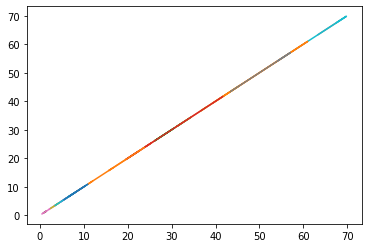

In [135]:
plt.plot(df_lang_5yr_prop_tp, df_lang_5yr_prop_tp)

Text(0, 0.5, 'Percentage (%)')

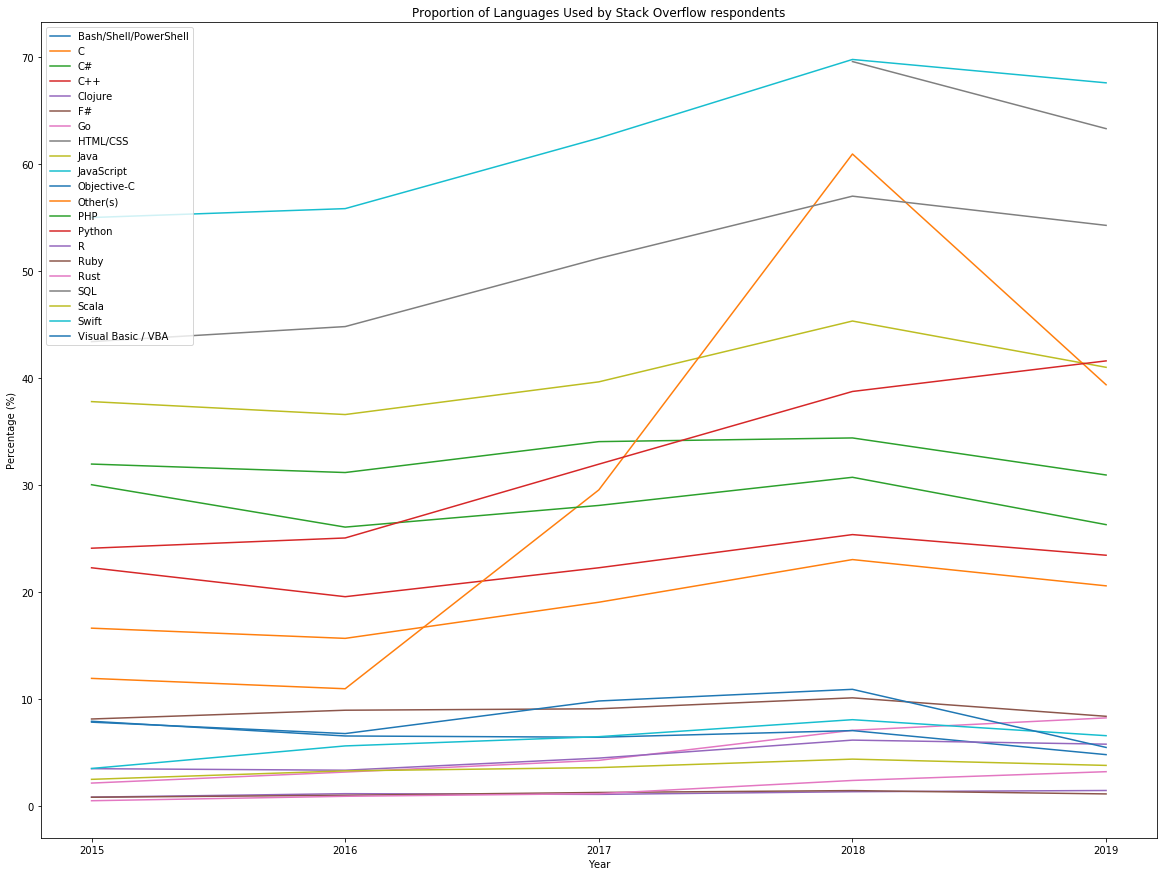

In [40]:
plt.figure(figsize = [20, 15])
plt.plot(df_lang_5yr_prop_tp)
plt.legend(df_lang_5yr_prop_tp.columns, loc = 'upper left')
plt.title('Proportion of Languages Used by Stack Overflow respondents')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
#labelLines(plt.gca().get_lines(),zorder=2.5)

<Figure size 1440x1080 with 0 Axes>

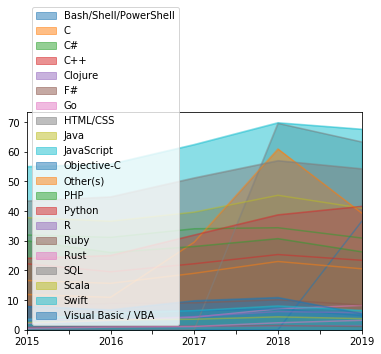

<Figure size 1440x1080 with 0 Axes>

In [33]:

df_lang_5yr_prop_tp.plot.area(stacked = False)
plt.figure(figsize = [20, 15])

In [ ]:
#sns.lineplot(data = df_lang_5yr_prop_tp)